This is the overall code to:
    1) Take the broadband r image, convert to nanomaggies and AB mags
    2) Add in background
    3) Produce an error image according to Poisson statistics (+ background + readnoise)
    4) Produce an error spectrum according to the same statistics (at each wavelength)
    5) Prepare to entre into ppxf according to the MaNGA specs

In [88]:
import pyfits
import matplotlib.pyplot as plt





import heapq

from pylab import *

from decimal import *
import numpy
from scipy.optimize import curve_fit
from scipy.integrate import quad

from astropy.modeling import models, fitting
from pylab import *
from scipy import stats
from scipy.stats import chisquare
import matplotlib.patches as patches
from astropy.io import fits
from astropy.convolution import Gaussian1DKernel
from astropy.convolution import Tophat2DKernel




import pyfits
import matplotlib.pyplot as plt

import heapq
import pyfits
import matplotlib as plt
from pylab import *
import numpy as np
from decimal import *
import numpy
from scipy.optimize import curve_fit
from scipy.integrate import quad
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from pylab import *
from scipy import stats
from scipy.stats import chisquare
import matplotlib.patches as patches



import numpy as np
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
import matplotlib.pyplot as pp
from scipy.ndimage import iterate_structure


import sys 
sys.path.append('/usr/local/lib/python2.7/site-packages/ppxf')
sys.path

from __future__ import print_function

from astropy.io import fits
import numpy as np

from os import path


plt.clf()

from astropy.convolution import convolve, convolve_fft
import matplotlib.pyplot as plt
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import Gaussian1DKernel
from astropy.convolution import convolve

import scipy.ndimage.filters as filters




In [2]:
#import masterslave as ms

import sys 
sys.path.append('/usr/local/lib/python2.7/site-packages/ppxf')
print(sys.path)
import pyfits
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import WMAP9 as cosmo
from astropy.convolution import Gaussian1DKernel
from astropy.convolution import convolve
from ppxf import ppxf
import ppxf_util as util
from matplotlib.colors import LogNorm
import glob
from time import clock

['', '/Users/beckynevin/anaconda/lib/python36.zip', '/Users/beckynevin/anaconda/lib/python3.6', '/Users/beckynevin/anaconda/lib/python3.6/lib-dynload', '/Users/beckynevin/anaconda/lib/python3.6/site-packages', '/Users/beckynevin/anaconda/lib/python3.6/site-packages/Sphinx-1.5.1-py3.6.egg', '/Users/beckynevin/anaconda/lib/python3.6/site-packages/aeosa', '/Users/beckynevin/anaconda/lib/python3.6/site-packages/setuptools-27.2.0-py3.6.egg', '/Users/beckynevin/anaconda/lib/python3.6/site-packages/IPython/extensions', '/Users/beckynevin/.ipython', '/usr/local/lib/python2.7/site-packages', '/usr/local/lib/python2.7/site-packages/ppxf', '/usr/local/lib/python2.7/site-packages/ppxf']


Number of Exposures 9
Plateid 7960 37 fibers 333
(333, 4563)
~~~~~~
We want to go from the raw data for NEXP x NFIBERS:


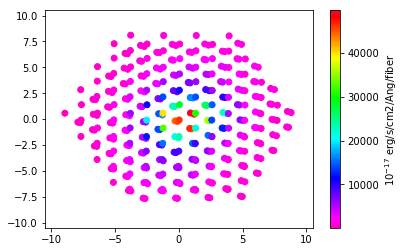

to the rebinned data (LOGCUBE):


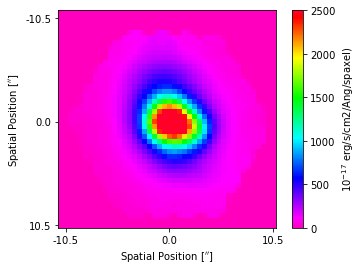

and eventually to the stellar velocity solutions:


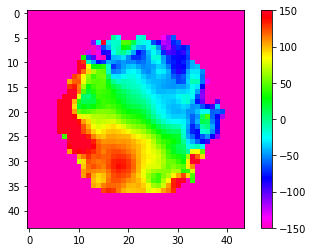

~~~~~~


In [155]:
plt.clf()
import os
os.chdir(os.path.expanduser('/Volumes/My Passport for Mac/LAURA_Sims/manga_test/'))





'''MAPS-SPX contain the stellar velocities on a grid'''
spec_check=pyfits.open('manga-7960-3701-MAPS-SPX-GAU-MILESHC.fits')


'''Logcube files contain the flux also rebinned to a grid'''
logcube=pyfits.open('manga-7960-3701-LOGCUBE.fits')




'''While LOGCUBE is in 44x44 dimensions (so already convolved),
LOGRSS is not and is in units of NFIBER x NEXP'''

'''Row-stacked, flux-calibrated fiber spectra for a given galaxy 
across all exposures. This file has logarithmic wavelength sampling 
from log10(lambda/Angstroms)=3.5589 to 4.0151 (NWAVE=4563 spectral 
elements). There is one row for each fiber, for a total of NFIBER*NEXP 
rows.'''

'''HDU #0 = Empty except for global header
HDU #1 [FLUX] = Row-stacked spectra from all exposures for the target in units of 10(-17) erg/s/cm2/Ang/fiber [NWAVE x (NFIBER*NEXP)]
HDU #2 [IVAR] = Inverse variance (1/sigma2) for the above [NWAVE x (NFIBER*NEXP)]
HDU #3 [MASK] = Pixel mask [NWAVE x (NFIBER*NEXP)] (defined values are set in https://trac.sdss.org/browser/repo/sdss/idlutils/trunk/data/sdss/sdssMaskbits.par) 
HDU #4 [DISP] = Broadened dispersion solution (1sigma LSF in units of Angstroms) [NWAVE x (NFIBER*NEXP)]
HDU #5 [WAVE] = Wavelength vector [NWAVE]
HDU #6 [SPECRES] = Median spectral resolution as a function of wavelength for the fibers in this IFU [NWAVE] 
HDU #7 [SPECRESD] = Standard deviation of spectral resolution as a function of wavelength for the fibers in this IFU [NWAVE] 
HDU #8 [OBSINFO] = Yanny-format structure detailing exposures that went into this file. [BINARY FITS TABLE]
HDU #9 [XPOS] = Array of fiber X-positions (units of arcsec) relative to the IFU center [NWAVE x (NFIBER*NEXP)]
HDU #10 [YPOS] = Array of fiber Y-positions (units of arcsec) relative to the IFU center [NWAVE x (NFIBER*NEXP)]'''

'''rss files contain the raw raw raw non-rebinned data'''
rss=pyfits.open('manga-7960-3701-LOGRSS.fits')
print('Number of Exposures', rss[0].header['NEXP'])
print('Plateid', rss[0].header['PLATEID'], '37 fibers', 37*9)
print(shape(rss['XPOS'].data))

xs=[]
ys=[]
summed_flux_per_fiber=[]
for i in range(37*9):
    xs.append(rss['XPOS'].data[i,0])
    ys.append(rss['YPOS'].data[i,0])
    summed_flux_per_fiber.append(np.sum(rss['FLUX'].data[i,:]))

print('~~~~~~')
print('We want to go from the raw data for NEXP x NFIBERS:')
plt.scatter(xs,ys,c=summed_flux_per_fiber, cmap='gist_rainbow_r')
plt.xlim([-10.5,10.5])
plt.ylim([-10.5,10.5])
plt.colorbar(label=r'10$^{-17}$ erg/s/cm2/Ang/fiber')
plt.show()

print('to the rebinned data (LOGCUBE):')
fig=plt.figure()
ax1=fig.add_subplot(111)

im1=ax1.imshow(np.sum(logcube['FLUX'].data, axis=0), vmin=0, vmax=2500,cmap='gist_rainbow_r')#norm=LogNorm(vmin=1, vmax=3500)
cbar1=plt.colorbar(im1,label=r'10$^{-17}$ erg/s/cm2/Ang/spaxel)')
length=shape(np.sum(logcube['FLUX'].data, axis=0))[0]

yticks=[1 ,length/2    ,length-1]
ylabels=[round((x-length/2)*0.5,1) for x in yticks]
ax1.set_yticks(yticks)
ax1.set_yticklabels(ylabels)
ax1.set_xticks(yticks)
ax1.set_xticklabels(ylabels)
ax1.set_ylabel(r'Spatial Position [$^{\prime \prime}$]')
ax1.set_xlabel(r'Spatial Position [$^{\prime \prime}$]')
plt.show()

print('and eventually to the stellar velocity solutions:')


plt.imshow(np.flipud(spec_check['STELLAR_VEL'].data), cmap='gist_rainbow_r',vmin=-150, vmax=150)
plt.colorbar()
plt.show()

print('~~~~~~')



In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111, aspect='equal')
kpc_arcmin=cosmo.kpc_proper_per_arcmin(0.1081)
pixelscale=0.5
pts=regrid(logcube, rss,0.1081)#30.3205)


'''The output of this is the locations of the fibers based upon the center of the IFU'''
'''Starting the new stuff now'''

extent=pts[2]

add_spec=summed_flux_per_fiber

spacing=0.5#arcsecond pixels
#we need to know the extent of the long axis of each fiber


n_horiz=length#int(round((extent-0.5)/spacing,1))/2
half_extent=length/2#round((extent-0.5)/2,1)

#plt.tight_layout()

xcoords=length/2
ycoords=length/2
cen_y=length/2
cen_x=length/2



xss=np.linspace(-n_horiz,n_horiz,2*n_horiz+1)
xs_line=np.linspace(-n_horiz-1, n_horiz, 2*n_horiz+2)
pts_horiz=[x*arc_to_pix(spacing)+xcoords for x in xss]
pts_vert=[x*arc_to_pix(spacing)+ycoords for x in xss]




print(len(add_spec), len(pts_horiz), len(pts_vert))
print(len(xs), len(ys))

'''Figure out how to make a grid '''
regrid_specs=[]
regrid_sum=[]
for i in range(len(pts_horiz)):
    for j in range(len(pts_vert)):
        #pts_horiz are where the rss locations are
        
        out=f_manga(pts_horiz[j], pts_vert[i], xs, ys, add_spec)
        regrid_specs.append(out[0])
        regrid_sum.append(out[1])
#print(regrid_sum)

plt.clf()

X, Y = np.meshgrid(pts_horiz,pts_vert)

fig=plt.figure()
ax1=fig.add_subplot(111,aspect='equal')
im1=ax1.scatter(X, Y, c=regrid_sum, s=10,cmap='gist_rainbow_r')
cbar1=plt.colorbar(im1,label='Relative Summed Spectral Flux')
#plt.scatter(X, Y, color='black')

#plt.xlim([0,300])
#plt.ylim([0,300])

'''for x in range(len(line_horiz)):
    ax1.axhline(y=line_vert[x], color='black')
    ax1.axvline(x=line_horiz[x], color='black')'''

yticks=[1 ,length/2    ,length-1]
ylabels=[round((x-length/2)*0.5,1) for x in yticks]
ax1.set_yticks(yticks)
ax1.set_yticklabels(ylabels)
ax1.set_xticks(yticks)
ax1.set_xticklabels(ylabels)
ax1.set_ylabel(r'Spatial Position [$^{\prime \prime}$]')
ax1.set_xlabel(r'Spatial Position [$^{\prime \prime}$]')
plt.tight_layout()


#plt.colorbar()
plt.show()





# fibers 37
shape (44, 44)
333 89 89
333 333


/Users/beckynevin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:38: RuntimeWarning: invalid value encountered in double_scalars


In [145]:
def f_manga(x, y, exist_x, exist_y, add_spec):
    '''take the points of the hexagon and find the nearest integral and 
    then you can find the value of that position'''
    weight=[]
    all_specs=[]
    spec_here=[]
    for Y in range(len(exist_x)):
        #print('x', x, exist_x[Y], 'y', y, exist_y[Y], r)
        r=((x-exist_x[Y])**2+(y-exist_y[Y])**2)
        '''print('x', x, exist_x[Y], 'y', y, exist_y[Y], r)
        print('arc to pix', arc_to_pix(1.6))'''
        if r > arc_to_pix(1.6)**2:
            '''This means you cannot include these pixels'''
            weight.append(0)
            spec_here.append(add_spec[Y])
            
        else:
            #print('within')
            weight.append(np.exp(-0.5*(r/arc_to_pix(0.7)**2)))
            
            spec_here.append(add_spec[Y])
    
    
    if weight==0:
        weight_norm=weight
        new_spec=(0)
        #print(len(new_spec))
        '''plt.plot(value, label='copied')
        plt.plot(new_spec, label='weighted')
        plt.annotate('Weight = '+str(round(weight,3)), xy=(0.09,0.9), xycoords='axes fraction')
        plt.legend()
        plt.show()'''
        all_specs.append(new_spec)
        
    else:
        weight_norm = np.sum(weight)
        for k in range(len(weight)):
            new_spec=(1/(4*np.pi))*(weight[k]*spec_here[k])/weight_norm
            #print(len(new_spec))
            ''' plt.plot(value, label='copied')
            plt.plot(new_spec, label='weighted')
            plt.annotate('Weight = '+str(round(weight[k],3)), xy=(0.09,0.9), xycoords='axes fraction')
            plt.legend()
            plt.show()'''
            all_specs.append(new_spec)
    
    '''Ive now gone through all the existing points and seen if
    the input points overlap'''
   
    
    if np.isnan(np.sum(all_specs)):
        sums=0
        double_sum=0
    else:
        sums=np.sum(all_specs, axis=0)
        double_sum=np.sum(sums)
        '''plt.clf()
        plt.plot(sums)
        plt.show()'''
    return sums, double_sum

In [115]:
def regrid(input_spec,raw_spec,  redshift):
    '''np.sum(logcube['FLUX'].data, axis=0),rss['FLUX'].data'''
    
    input_spec=np.sum(input_spec['FLUX'].data, axis=0)
    n_exp=rss[0].header['NEXP']
    fiber=int(shape(rss['FLUX'].data)[0]/n_exp)
    
    print('# fibers', fiber)
    print('shape', shape(input_spec))
    
    '''the fiber bundle will center at xmax, ymax'''
    xmin=0
    xmax=shape(input_spec)[0]
    ymin=0
    ymax=shape(input_spec)[1]
    
    xcoord=shape(input_spec)[0]/2
    ycoord=shape(input_spec)[1]/2
    
    pixelscale=0.5
    kpc_arcmin=cosmo.kpc_proper_per_arcmin(redshift)
    
    
    
    spacing=2.5/pixelscale
    radius = 1/pixelscale
    correction = 0.25/pixelscale
    scaling=pixelscale

    
    p=plotting_fibers_manga(fiber, xmin, xcoord, ycoord, ycoord, spacing, radius, correction)
    broadband_cut=input_spec
    #MIDDLE DIMENSION IS ACTUALLY THE YS
    #ax1.imshow(np.sum(CAMERA0.data[:,:,:],axis=0),vmax=10000)
    im1=ax1.imshow(np.flipud(broadband_cut), vmin=0, vmax=2500,cmap='gist_rainbow_r',interpolation='none',origin='lower')
    
    yticks=[0+1 ,xmax/2    ,xmax-1]
    ylabels=[round((x-xmax/2)*scaling,1) for x in yticks]
    ax1.set_yticks(yticks)
    ax1.set_yticklabels(ylabels)
    ax1.set_xticks(yticks)
    ax1.set_xticklabels(ylabels)
    ax1.set_ylabel(r'Spatial Position [$^{\prime \prime}$]')
    ax1.set_xlabel(r'Spatial Position [$^{\prime \prime}$]')
    ax1.set_xlabel(str(round(pixelscale/2,2))+r' kpc')
    #plt.tight_layout()
    #plt.show()
    plt.colorbar(im1, orientation='vertical', label='Relative Flux')
    savefig('Simulated_fiber_convolved_manga.pdf')
    
    '''Okay but how do we extract at those positions'''

    
    
    '''At each position if the x, y coordinates are within some radius, sum together the spectra
    to make a third dimension of the array
    Coords should be p[0], p[1], and the summed flux'''
    corr_p1=[300-x for x in p[1]]
    return p[0], p[1], p[2]

In [124]:
def plotting_fibers_manga(n_fibers, xmin, xmax, ymin, ymax, spacing, radius, correction):
    
    '''input is the effective radius
    1) Convert r_e to arcsec
    2) Determine which fiber to use'''
    if n_fibers==7:
        index_1=[-1,0]
        index_2=[1,1]
        index_3=[3,2]
    
    if n_fibers==19:
        index_1=[-2,-1,-1]
        index_2=[2,2,1]
        index_3=[5,4,3]
    
    if n_fibers==37:
        index_1=[-3,-2,-2,-1]
        index_2=[3,3,2,2]
        index_3=[7,6,5,4]
    
    if n_fibers==61:
        index_1=[-4,-3,-3,-2,-2]
        index_2=[4,4,3,3,2,2]
        index_3=[9,8,7,6,5]
    
    if n_fibers==91:
        xs_0=[-5,5,11]
        xs_1=[-4,5,10]
        xs_2=[-4,4,9]
        xs_3=[-3,4,8]
        xs_4=[-3,3,7]
        xs_5=[-2,3,6]
        
        '''Converting into a better format'''
        index_1=[-5,-4,-4,-3,-3,-2]
        index_2=[5,5,4,4,3,3]
        index_3=[11,10,9,8,7,6]

    if n_fibers==127:
        index_1=[-6,-5,-5,-4,-4,-3,-3]
        index_2=[6,6,5,5,4,4,3]
        index_3=[13,12,11,10,9,8,7]
    

    x_coords=[]
    y_coords=[]
    for i in range(len(index_1)):
        xs=np.linspace(index_1[i],index_2[i],index_3[i])
        xs=np.array(xs)
        if i % 2 == 0:#n % 2 == 0
                #in other words, if its an odd index you need to play with spacing
            
            corr=0   
        else:
            
            corr=radius+correction
        
        for k in range(len(xs)):
            if i==0:#this is to only plot once for the middle row
              
                rect = patches.Circle((xmin+(xmax-xmin)+xs[k]*spacing-corr,ymin+i*np.sin(math.radians(60))*spacing),radius,linewidth=1,edgecolor='white',facecolor='none')
                ax1.add_patch(rect)
                x_coords.append(xmin+(xmax-xmin)+xs[k]*spacing-corr)
                y_coords.append(ymin+i*np.sin(math.radians(60))*spacing)
            else:
                rect = patches.Circle((xmin+(xmax-xmin)+xs[k]*spacing-corr,ymin+i*np.sin(math.radians(60))*spacing),radius,linewidth=1,edgecolor='white',facecolor='none')
                #if (xrows[2]-xsub)/2 == 0:#in other words, if its odd
                ax1.add_patch(rect)
                x_coords.append(xmin+(xmax-xmin)+xs[k]*spacing-corr)
                y_coords.append(ymin+i*np.sin(math.radians(60))*spacing)
                rect = patches.Circle((xmin+(xmax-xmin)+xs[k]*spacing-corr,ymin-i*np.sin(math.radians(60))*spacing),radius,linewidth=1,edgecolor='white',facecolor='none')
                #if (xrows[2]-xsub)/2 == 0:#in other words, if its odd
                ax1.add_patch(rect)
                x_coords.append(xmin+(xmax-xmin)+xs[k]*spacing-corr)
                y_coords.append(ymin-i*np.sin(math.radians(60))*spacing)
    '''I'd also like to plot a huge line scale for the full diameter of the packet (in kpc and "?)'''
    #ax1.axhline(y=ymin+(len(index_1)+2)*np.sin(math.radians(60))*spacing,xlim=(xmin+(xmax-xmin)+index_1[0]*spacing,xmin+(xmax-xmin)+index_2[0]*spacing), color='white', lw=2)
    from matplotlib import collections  as mc

    lines = [[(xmin+(xmax-xmin)+index_1[0]*spacing-radius-arc_to_pix(0.25),ymin+(len(index_1)+1)*np.sin(math.radians(60))*spacing),(xmin+(xmax-xmin)+index_2[0]*spacing+radius+arc_to_pix(0.25),ymin+(len(index_1)+1)*np.sin(math.radians(60))*spacing)]]
    
    #lines = [[(xmin+(xmax-xmin)+index_1[0]*spacing-radius,ymin),(xmin+(xmax-xmin)+index_2[0]*spacing+radius,ymin)]]
    
    length=(xmin+(xmax-xmin)+index_2[0]*spacing+radius+arc_to_pix(0.25))-(xmin+(xmax-xmin)+index_1[0]*spacing-radius-arc_to_pix(0.25))
    '''This is a length in pixels'''
    length_kpc=length*pixelscale
    '''Now its in kpc'''
    length_arc=length_kpc/(kpc_arcmin.value/60)
    ax1.annotate(str(round(length_arc,1))+r'$^{\prime\prime}$',xy=(xmin+(xmax-xmin)+index_1[0]*spacing-radius,ymin+(1.5*len(index_1))*np.sin(math.radians(60))*spacing),xycoords='data', size=15, color='white')
    
    lc = mc.LineCollection(lines, colors='white', linewidths=2)
    
    ax1.add_collection(lc)
    
    
    #plt.segments(x0=xmin+(xmax-xmin)+index_1[0]*spacing,x1=xmin+(xmax-xmin)+index_2[0]*spacing,y0=ymin+(len(index_1)+2)*np.sin(math.radians(60))*spacing)
    return x_coords, y_coords, length_arc

def sum_fibers_manga(fiber_x, fiber_y, min_x, min_y, max_x, max_y, spec):
    '''Draw a box around the fiber region, extract just those
    values of i and j'''
    mask_2d=np.zeros((len(spec['FLUX'].data[:,0,0]),len(spec['FLUX'].data[0,:,0]),len(spec['FLUX'].data[0,0,:])))
    
    mask_2d[:, :min_y, :min_x] = 1
    mask_2d[:, max_y:, max_x:] = 1
    
    '''plt.clf()
    plt.imshow(np.sum(CAMERA0.data[:,min_y:max_y,min_x:max_x], axis=0), vmax=1e5)
    plt.colorbar()
    plt.show()'''
    
    for i in range(max_x-min_x):
        for j in range(max_y-min_y):
            xs=i+min_x
            ys=j+min_y
            
            if (fiber_x-xs)**2+(fiber_y-ys)**2 < arc_to_pix(1)**2:
                continue
            else:
                mask_2d[:,ys,xs]=1
    masked_cube= np.ma.masked_array(spec['FLUX'].data[:,:,:], mask=mask_2d)
    return np.sum(masked_cube, axis=(1,2))
    

In [ ]:
##Everything below here is old

In [8]:
spec=pyfits.open('mcrx_200.fits')

fig = plt.figure()
ax1 = fig.add_subplot(111, aspect='equal')
pts=simplify(spec, 30)#30.3205)
extent=pts[2]

print(len(pts[0]))






0.2746988752967151 arcsec per pixel
12.36144938835218 arcsec
fiber 127
127


In [156]:
arc_to_pix(1)

3.640364376941299

147.394752768 131.710468717 256.605247232 226.289531283
146 130 257 227


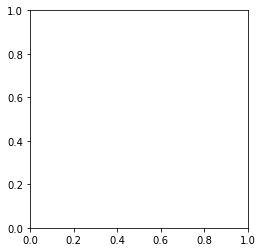

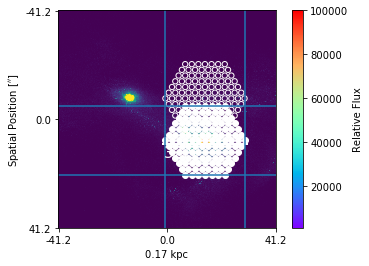

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126


'The output is pts[0], pts[1], \nand the add_spec is now the spectra for each dimension'

In [9]:

add_spec=[]
#np.zeros((len(CAMERA0.data[:,0,0]),len(CAMERA0.data[0,:,0]),len(CAMERA0.data[0,0,:])))

counter=0
print(min(pts[0]), min(pts[1]), max(pts[0]), max(pts[1]))
print(int(min(pts[0])-1), int(min(pts[1])-1), int(max(pts[0])+1), int(max(pts[1])+1))

xcoord=202
ycoord=179

plt.imshow((np.sum(CAMERA0.data[:,:,:], axis=0)), vmax=1e5)
plt.axhline(y=min(pts[1]))
plt.axhline(y=max(pts[1]))

plt.axvline(x=min(pts[0]))
plt.axvline(x=max(pts[0]))
plt.scatter(xcoord,ycoord, color='red')
for i in range(len(pts[0])):
    plt.scatter(pts[0][i], pts[1][i], color='white')
#plt.colorbar()
plt.show()

#stop


'''plt.imshow((np.sum(CAMERA0.data[:,:,:int(min(pts[0])-1)], axis=0)), vmax=1e5)
plt.show()

plt.imshow((np.sum(CAMERA0.data[:,:int(min(pts[1])-1),:], axis=0)), vmax=1e5)
plt.show()

plt.imshow((np.sum(CAMERA0.data[:,:,int(max(pts[0])-1):], axis=0)), vmax=1e5)
plt.show()

plt.imshow((np.sum(CAMERA0.data[:,int(max(pts[1])-1):,:], axis=0)), vmax=1e5)
plt.show()'''




for i in range(len(pts[0])):#
    in_x=pts[0][i]
    in_y=pts[1][i]
    s=sum_fibers(in_x, in_y, int(min(pts[0])-arc_to_pix(1)), int(min(pts[1])-arc_to_pix(1)), int(max(pts[0])+arc_to_pix(1)), int(max(pts[1])+arc_to_pix(1)))
    print(counter)
    add_spec.append(s)
    counter+=1
    

    
'''The output is pts[0], pts[1], 
and the add_spec is now the spectra for each dimension'''


In [10]:
print(shape((np.sum(add_spec, axis=1))))
norm_this=(np.sum(add_spec, axis=1))

normed=[(x-min(norm_this))/(max(norm_this)-min(norm_this)) for x in norm_this]
#$value - $min) / ($max - $min);

'''Is the middle point always going to be a nice number?'''
spacing=0.5#arcsecond pixels
#we need to know the extent of the long axis of each fiber


n_horiz=int(round((extent-0.5)/spacing,1))/2
half_extent=round((extent-0.5)/2,1)
print('extent', extent, half_extent)

plt.clf()
fig=plt.figure()
ax1=fig.add_subplot(111, aspect='equal')
im1=ax1.scatter(pts[0],pts[1], c=normed, s=100)
cbar1=plt.colorbar(im1, label='Relative Summed Spectral Flux')
#plt.tight_layout()
cen_x=202
cen_y=179#was 121
yticks=[-arc_to_pix(half_extent)+cen_y, cen_y, cen_y+arc_to_pix(half_extent)]
ylabels=[-half_extent, 0, half_extent]
ax1.set_yticks(yticks)
ax1.set_yticklabels(ylabels)

xticks=[-arc_to_pix(half_extent)+cen_x, cen_x, cen_x+arc_to_pix(half_extent)]
xlabels=[-half_extent, 0, half_extent]
ax1.set_xticks(xticks)
ax1.set_xticklabels(xlabels)
ax1.set_ylabel(r'Spatial Position [$^{\prime \prime}$]')
ax1.set_xlabel(r'Spatial Position [$^{\prime \prime}$]')
savefig('127_articifical.pdf')

'''Make an artifically grid system centered on the middle position here'''

print(pts[0])
print(pts[1])


arc_to_pix(spacing)
arc_to_pix(extent)

xs=np.linspace(-n_horiz,n_horiz,2*n_horiz+1)
xs_line=np.linspace(-n_horiz-1, n_horiz, 2*n_horiz+2)
pts_horiz=[x*arc_to_pix(spacing)+202 for x in xs]
pts_vert=[x*arc_to_pix(spacing)+179 for x in xs]
line_horiz=[x*arc_to_pix(spacing)+arc_to_pix(0.25)+202 for x in xs_line]
line_vert=[x*arc_to_pix(spacing)+arc_to_pix(0.25)+179 for x in xs_line]

plt.clf()
X, Y = np.meshgrid(pts_horiz,pts_vert)


fig=plt.figure()
ax1=fig.add_subplot(111,aspect='equal')
im1=ax1.scatter(pts[0],pts[1], c=normed, s=100)
cbar1=plt.colorbar(im1,label='Relative Summed Spectral Flux')
#plt.scatter(X, Y, color='black')

#plt.xlim([0,300])
#plt.ylim([0,300])

for x in range(len(line_horiz)):
    ax1.axhline(y=line_vert[x], color='black')
    ax1.axvline(x=line_horiz[x], color='black')

yticks=[-arc_to_pix(half_extent)+cen_y, cen_y, cen_y+arc_to_pix(half_extent)]
ylabels=[-half_extent, 0, half_extent]
ax1.set_yticks(yticks)
ax1.set_yticklabels(ylabels)

xticks=[-arc_to_pix(half_extent)+cen_x, cen_x, cen_x+arc_to_pix(half_extent)]
xlabels=[-half_extent, 0, half_extent]
ax1.set_xticks(xticks)
ax1.set_xticklabels(xlabels)
ax1.set_ylabel(r'Spatial Position [$^{\prime \prime}$]')
ax1.set_xlabel(r'Spatial Position [$^{\prime \prime}$]')
plt.tight_layout()
savefig('regrid_127.pdf')

(127,)
extent 32.49987199999994 16.0
[147.39475276774323, 156.49562730645269, 165.59650184516215, 174.69737638387161, 183.79825092258108, 192.89912546129054, 202.0, 211.10087453870946, 220.20174907741892, 229.30262361612839, 238.40349815483785, 247.50437269354731, 256.60524723225677, 151.94519003709797, 151.94519003709797, 161.04606457580741, 161.04606457580741, 170.1469391145169, 170.1469391145169, 179.24781365322633, 179.24781365322633, 188.34868819193582, 188.34868819193582, 197.44956273064525, 197.44956273064525, 206.55043726935475, 206.55043726935475, 215.65131180806418, 215.65131180806418, 224.75218634677367, 224.75218634677367, 233.8530608854831, 233.8530608854831, 242.95393542419259, 242.95393542419259, 252.05480996290203, 252.05480996290203, 156.49562730645269, 156.49562730645269, 165.59650184516215, 165.59650184516215, 174.69737638387161, 174.69737638387161, 183.79825092258108, 183.79825092258108, 192.89912546129054, 192.89912546129054, 202.0, 202.0, 211.10087453870946, 211.1

In [119]:
'''plt.scatter(pts[0],pts[1], c=np.sum(add_spec,axis=0))
plt.colorbar()
plt.show()'''

def simplify(input_spec, r_e):
    '''Input r_e should be in pixels'''
    '''Find out the value of 1 pixel'''
    
    CAMERA0=spec[25]
    
    pixelscale=(CAMERA0.header['CD1_1']) #this is kpc per pixel
    
    kpc_arcmin=cosmo.kpc_proper_per_arcmin(0.03)
    scaling=pixelscale/(kpc_arcmin.value/60)
    print(scaling, 'arcsec per pixel')
    Ang=[x[0]*10**(10) for x in spec[5].data]#
    
    '''Use the effective radius to convert to an effective radius of the fiber bundle'''
    r_e_fiber_equiv=1.5*r_e*scaling
    print(r_e_fiber_equiv, 'arcsec')
    
    if r_e_fiber_equiv > 12.27:
        fiber=127
    else:
        if r_e_fiber_equiv > 10.00:
            fiber=91
        else:
            if r_e_fiber_equiv > 7.73:
                fiber=61
            else:
                if r_e_fiber_equiv >5.45:
                    fiber=19
                else:
                    fiber=7
    '''Now, based upon the fiber that we can use, we can
    place that given bundle'''
    print('fiber', fiber)
    
    '''the fiber bundle will center at xmax, ymax'''
    xmin=0
    xmax=300
    ymin=0
    ymax=300
    
    xcoord=202
    ycoord=300-179
    
    
    
    spacing=(2.5*(kpc_arcmin.value/60))/pixelscale
    radius = (1*(kpc_arcmin.value/60))/pixelscale
    correction = (0.25*(kpc_arcmin.value/60))/pixelscale

    
    p=plotting_fibers_r_e(fiber, xmin, xcoord, ycoord, ycoord, spacing, radius, correction)
    broadband_cut=np.sum(CAMERA0.data[:,xmin:xmax,ymin:ymax],axis=0)
    #MIDDLE DIMENSION IS ACTUALLY THE YS
    #ax1.imshow(np.sum(CAMERA0.data[:,:,:],axis=0),vmax=10000)
    im1=ax1.imshow(np.flipud(broadband_cut),vmin=10**3, vmax=10**5, cmap='rainbow',interpolation='none',origin='lower')
    
    yticks=[0 ,xmax/2    ,xmax]
    ylabels=[round((x-xmax/2)*scaling,1) for x in yticks]
    ax1.set_yticks(yticks)
    ax1.set_yticklabels(ylabels)
    ax1.set_xticks(yticks)
    ax1.set_xticklabels(ylabels)
    ax1.set_ylabel(r'Spatial Position [$^{\prime \prime}$]')
    ax1.set_xlabel(r'Spatial Position [$^{\prime \prime}$]')
    ax1.set_xlabel(str(round(pixelscale,2))+r' kpc')
    #plt.tight_layout()
    #plt.show()
    plt.colorbar(im1, orientation='vertical', label='Relative Flux')
    savefig('Simulated_fiber_convolved_manga.pdf')
    
    '''Okay but how do we extract at those positions'''

    
    
    '''At each position if the x, y coordinates are within some radius, sum together the spectra
    to make a third dimension of the array
    Coords should be p[0], p[1], and the summed flux'''
    corr_p1=[300-x for x in p[1]]
    return p[0], corr_p1, p[2]
    
'''At each position if the x, y coordinates are within some radius, sum together the 
spectra to make a third dimension of the array
Coords should be p[0], p[1], and the summed flux'''
def sum_fibers(fiber_x, fiber_y, min_x, min_y, max_x, max_y):
    '''Draw a box around the fiber region, extract just those
    values of i and j'''
    mask_2d=np.zeros((len(CAMERA0.data[:,0,0]),len(CAMERA0.data[0,:,0]),len(CAMERA0.data[0,0,:])))
    
    mask_2d[:, :min_y, :min_x] = 1
    mask_2d[:, max_y:, max_x:] = 1
    
    '''plt.clf()
    plt.imshow(np.sum(CAMERA0.data[:,min_y:max_y,min_x:max_x], axis=0), vmax=1e5)
    plt.colorbar()
    plt.show()'''
    
    for i in range(max_x-min_x):
        for j in range(max_y-min_y):
            xs=i+min_x
            ys=j+min_y
            
            if (fiber_x-xs)**2+(fiber_y-ys)**2 < arc_to_pix(1)**2:
                continue
            else:
                mask_2d[:,ys,xs]=1
    masked_cube= np.ma.masked_array(CAMERA0.data[:,:,:], mask=mask_2d)
    return np.sum(masked_cube, axis=(1,2))



def f(x, y, exist_x, exist_y, add_spec):
    '''take the points of the hexagon and find the nearest integral and 
    then you can find the value of that position'''
    weight=[]
    all_specs=[]
    spec_here=[]
    for Y in range(len(add_spec)):
        
        r=((x-exist_x[Y])**2+(y-exist_y[Y])**2)
        '''print('x', x, exist_x[Y], 'y', y, exist_y[Y], r)
        print('arc to pix', arc_to_pix(1.6))'''
        if r > arc_to_pix(1.6)**2:
            '''This means you cannot include these pixels'''
            weight.append(0)
            spec_here.append(add_spec[Y])
            
        else:
            #print('within')
            weight.append(np.exp(-0.5*(r/arc_to_pix(0.7)**2)))
            
            spec_here.append(add_spec[Y])
    
    
    if weight==0:
        weight_norm=weight
        new_spec=(0)
        #print(len(new_spec))
        '''plt.plot(value, label='copied')
        plt.plot(new_spec, label='weighted')
        plt.annotate('Weight = '+str(round(weight,3)), xy=(0.09,0.9), xycoords='axes fraction')
        plt.legend()
        plt.show()'''
        all_specs.append(new_spec)
        
    else:
        weight_norm = np.sum(weight)
        for k in range(len(weight)):
            new_spec=(1/(4*np.pi))*(weight[k]*spec_here[k])/weight_norm
            #print(len(new_spec))
            ''' plt.plot(value, label='copied')
            plt.plot(new_spec, label='weighted')
            plt.annotate('Weight = '+str(round(weight[k],3)), xy=(0.09,0.9), xycoords='axes fraction')
            plt.legend()
            plt.show()'''
            all_specs.append(new_spec)
    
    '''Ive now gone through all the existing points and seen if
    the input points overlap'''
   
    
    if np.isnan(np.sum(all_specs)):
        sums=0
        double_sum=0
    else:
        sums=np.sum(all_specs, axis=0)
        double_sum=np.sum(sums)
        '''plt.clf()
        plt.plot(sums)
        plt.show()'''
    return sums, double_sum

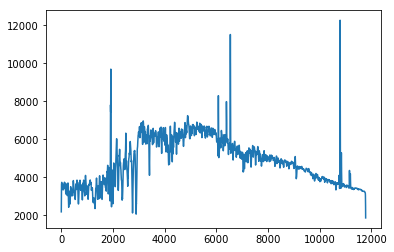

127 127
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [22]:


plt.clf()
plt.plot(add_spec[0])
plt.show()
print(len(pts[0]), len(add_spec))

'''Figure out how to make a grid '''
regrid_specs=[]
regrid_sum=[]
for i in range(len(pts_horiz)):
    for j in range(len(pts_vert)):
        #print(pts_horiz[i], pts_vert[j])
        #print(pts[0], pts[1])
        
        out=f(pts_horiz[j], pts_vert[i], pts[0], pts[1], add_spec)
        regrid_specs.append(out[0])
        regrid_sum.append(out[1])
print(regrid_sum)

In [ ]:
saved_regrid_sum=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4514368.0, 4514368.0, 4514368.0, 0.0, 0.0, 4516966.0, 4516966.0, 4516966.0, 0.0, 0.0, 4528315.0, 4528315.0, 4528315.0, 0.0, 0.0, 4517364.5, 4517364.5, 4517364.5, 0.0, 0.0, 4516610.0, 4516610.0, 4516610.0, 0.0, 0.0, 4516798.0, 4516798.0, 4516798.0, 0.0, 0.0, 4514447.5, 4514448.0, 4514447.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4514368.0, 4514368.0, 4514368.0, 4514368.0, 4514368.0, 4516966.0, 4516966.0, 4516966.0, 4516966.0, 4516966.0, 4528315.0, 4528315.0, 4528315.0, 4528315.0, 4528315.0, 4517364.5, 4517364.5, 4517364.5, 4517364.5, 4517364.5, 4516610.0, 4516610.0, 4516610.0, 4516610.0, 4516610.0, 4516798.0, 4516798.0, 4516798.0, 4516798.0, 4516798.0, 4514448.0, 4514448.0, 4514448.0, 4514448.0, 4514448.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4514368.0, 4514368.0, 4514368.0, 4514368.0, 4514368.0, 4514935.0, 4516399.0, 4516966.0, 4516966.0, 4516966.0, 4519444.0, 4525837.0, 4528315.0, 4528315.0, 4528315.0, 4525924.0, 4519755.0, 4517364.5, 4517364.5, 4517364.5, 4517199.5, 4516774.0, 4516610.0, 4516610.0, 4516610.0, 4516651.0, 4516757.0, 4516798.0, 4516798.0, 4516798.0, 4516285.0, 4514960.5, 4514448.0, 4514448.0, 4514448.0, 4514447.5, 4514448.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4514368.0, 4514368.0, 4514368.0, 4514368.0, 4514368.0, 4514935.0, 4516398.5, 4516966.0, 4516966.0, 4516966.0, 4519444.0, 4525837.5, 4528315.0, 4528315.0, 4528315.0, 4525924.0, 4519755.5, 4517364.5, 4517364.5, 4517364.5, 4517200.0, 4516774.5, 4516610.0, 4516610.0, 4516610.0, 4516651.0, 4516757.0, 4516798.0, 4516798.0, 4516798.0, 4516285.0, 4514960.5, 4514447.5, 4514448.0, 4514448.0, 4514447.5, 4514448.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4514368.0, 4514368.0, 4514368.0, 4514368.0, 4514368.0, 4514935.0, 4516398.5, 4516966.0, 4516966.0, 4516966.0, 4519444.0, 4525838.0, 4528315.0, 4528315.0, 4528315.0, 4525924.0, 4519756.0, 4517364.5, 4517364.5, 4517364.5, 4517200.0, 4516774.5, 4516610.0, 4516610.0, 4516610.0, 4516651.0, 4516757.0, 4516798.0, 4516798.0, 4516798.0, 4516285.0, 4514961.0, 4514448.0, 4514448.0, 4514448.0, 4514448.0, 4514447.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4517615.0, 4517615.0, 4516427.0, 4515427.0, 4514368.0, 4517614.5, 4520681.5, 4521633.0, 4519365.5, 4516966.0, 4522422.0, 4527575.0, 4531730.0, 4530071.0, 4528315.0, 4527973.0, 4527650.5, 4523642.0, 4520593.0, 4517364.5, 4519810.0, 4522119.0, 4521843.0, 4519301.0, 4516610.0, 4518205.5, 4519712.0, 4519780.5, 4518332.0, 4516798.0, 4516115.0, 4515470.0, 4514610.0, 4514531.0, 4514448.0, 4514577.0, 4514699.5, 4514844.0, 4514844.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4517615.0, 4517615.0, 4517615.0, 4517615.0, 4517015.0, 4519063.0, 4522485.0, 4524327.0, 4524327.0, 4522965.5, 4525533.0, 4530605.0, 4533701.5, 4533701.0, 4532704.5, 4529857.5, 4527461.0, 4527267.0, 4527267.0, 4525435.0, 4523552.0, 4523477.0, 4524865.0, 4524865.0, 4523338.0, 4521284.5, 4520598.0, 4521503.0, 4521503.0, 4520633.0, 4517726.0, 4515091.0, 4514704.0, 4514704.0, 4514657.0, 4514680.0, 4514771.0, 4514844.0, 4514844.0, 4514844.0, 4514844.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4517615.0, 4517615.0, 4517615.0, 4517615.0, 4517615.0, 4520970.5, 4524327.0, 4524327.0, 4524327.0, 4524327.0, 4529014.0, 4533701.5, 4533701.0, 4533701.5, 4533701.5, 4530484.0, 4527267.0, 4527267.0, 4527267.0, 4527267.0, 4526066.0, 4524865.0, 4524865.0, 4524865.0, 4524865.0, 4523184.0, 4521503.0, 4521503.0, 4521503.0, 4521503.0, 4518103.0, 4514704.0, 4514704.0, 4514704.0, 4514704.0, 4514774.0, 4514844.0, 4514844.0, 4514844.0, 4514844.0, 4514844.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4517615.0, 4517615.0, 4517615.0, 4517615.0, 4517615.0, 4520971.0, 4524327.0, 4524327.0, 4524327.0, 4524327.0, 4529014.0, 4533701.5, 4533701.0, 4533701.0, 4533701.5, 4530484.0, 4527267.0, 4527267.0, 4527267.0, 4527267.0, 4526066.0, 4524865.0, 4524865.0, 4524865.0, 4524865.0, 4523184.0, 4521503.0, 4521503.0, 4521503.0, 4521503.0, 4518103.5, 4514704.0, 4514704.0, 4514704.0, 4514704.0, 4514774.0, 4514844.0, 4514844.0, 4514844.0, 4514844.0, 4514844.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4527138.0, 4523448.0, 4520531.5, 4517615.0, 4517615.0, 4528329.0, 4534934.0, 4532987.0, 4524327.0, 4524327.0, 4531642.0, 4537489.5, 4538146.0, 4533701.0, 4533701.5, 4536806.0, 4536380.0, 4532342.5, 4527267.0, 4527267.0, 4530934.5, 4531883.0, 4529268.5, 4524865.0, 4524865.0, 4528070.0, 4528546.0, 4525737.5, 4521503.0, 4521503.0, 4524087.0, 4523328.0, 4519369.0, 4514704.0, 4514704.0, 4516909.0, 4517921.0, 4517006.0, 4514844.0, 4514844.0, 4514076.0, 4513309.0, 4512337.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4527138.0, 4527138.0, 4527138.0, 4525241.5, 4522652.5, 4536121.5, 4545634.5, 4552604.0, 4546972.0, 4539285.0, 4536962.0, 4543456.5, 4548215.0, 4545324.0, 4541378.0, 4539064.5, 4541821.5, 4543841.0, 4540540.0, 4536034.0, 4533602.5, 4536858.5, 4539244.0, 4536380.0, 4532471.0, 4530401.0, 4533246.0, 4535330.5, 4532576.5, 4528817.0, 4525965.0, 4528259.0, 4529939.0, 4526904.0, 4522762.0, 4518513.0, 4520470.0, 4521904.0, 4520498.0, 4518578.0, 4513518.0, 4512836.0, 4512337.0, 4512337.0, 4512337.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4527138.0, 4527138.0, 4527138.0, 4527138.0, 4527138.0, 4532697.0, 4547043.5, 4552604.0, 4552604.0, 4552604.0, 4551646.0, 4549173.5, 4548215.0, 4548215.0, 4548215.0, 4547260.0, 4544796.0, 4543841.0, 4543841.0, 4543841.0, 4542837.5, 4540247.5, 4539244.0, 4539244.0, 4539244.0, 4538389.5, 4536185.0, 4535330.5, 4535330.5, 4535330.5, 4534153.0, 4531116.0, 4529939.0, 4529939.0, 4529939.0, 4528185.0, 4523658.0, 4521904.0, 4521904.0, 4521904.0, 4519815.0, 4514425.5, 4512337.5, 4512337.0, 4512337.0, 4512337.0, 4512337.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4527138.0, 4527138.0, 4527138.0, 4527138.0, 4527138.0, 4532697.0, 4547044.0, 4552604.0, 4552604.0, 4552604.0, 4551646.0, 4549173.0, 4548215.0, 4548215.0, 4548215.0, 4547260.0, 4544796.0, 4543841.0, 4543841.0, 4543841.0, 4542837.5, 4540247.5, 4539244.0, 4539244.0, 4539244.0, 4538390.0, 4536185.0, 4535330.5, 4535330.5, 4535330.5, 4534153.0, 4531116.0, 4529939.0, 4529939.0, 4529939.0, 4528185.0, 4523658.0, 4521904.0, 4521904.0, 4521904.0, 4519815.0, 4514425.5, 4512337.0, 4512337.0, 4512337.0, 4512337.0, 4512337.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4536179.5, 4529734.0, 4527138.0, 4527138.0, 4527138.0, 4541086.0, 4559241.0, 4552604.0, 4552604.0, 4552604.0, 4562299.5, 4559171.5, 4548215.0, 4548215.0, 4548215.0, 4555570.0, 4552452.0, 4543841.0, 4543841.0, 4543841.0, 4548305.5, 4545029.0, 4539244.0, 4539244.0, 4539244.0, 4540756.0, 4537966.0, 4535330.5, 4535330.5, 4535330.5, 4534328.5, 4530485.5, 4529939.0, 4529939.0, 4529939.0, 4529597.5, 4523869.5, 4521904.0, 4521904.0, 4521904.0, 4523708.5, 4516888.0, 4512337.0, 4512337.0, 4512337.0, 4513020.0, 4514716.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4536179.5, 4536179.5, 4534243.5, 4531714.5, 4527138.0, 4551723.5, 4565313.0, 4570768.0, 4564302.5, 4552604.0, 4569693.0, 4579139.0, 4578200.0, 4567526.5, 4548215.0, 4561178.0, 4568344.0, 4567407.0, 4559018.5, 4543841.0, 4551710.0, 4556060.0, 4555075.0, 4549440.5, 4539244.0, 4541909.0, 4543382.0, 4542544.0, 4539976.0, 4535330.5, 4533564.5, 4532588.0, 4531433.5, 4530901.5, 4529939.0, 4529337.0, 4529004.0, 4527283.0, 4525368.0, 4521904.0, 4525084.0, 4526842.0, 4524793.0, 4520359.0, 4512337.0, 4513541.0, 4514206.5, 4514716.0, 4514716.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4536179.5, 4536179.5, 4536179.5, 4536179.5, 4536179.5, 4555947.0, 4575718.5, 4575718.5, 4575718.0, 4575718.5, 4581044.0, 4586372.0, 4586372.0, 4586372.0, 4586372.0, 4580101.0, 4573830.0, 4573830.0, 4573830.0, 4573830.0, 4566610.5, 4559390.5, 4559390.5, 4559390.5, 4559390.5, 4551950.0, 4544510.0, 4544510.0, 4544510.0, 4544510.0, 4538175.0, 4531841.0, 4531841.0, 4531841.0, 4531841.0, 4530295.0, 4528749.5, 4528749.5, 4528749.5, 4528749.5, 4528469.0, 4528188.0, 4528188.0, 4528188.0, 4528188.0, 4521451.0, 4514716.0, 4514716.0, 4514716.0, 4514716.0, 4514716.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4536179.5, 4536179.5, 4536179.5, 4536179.5, 4536179.5, 4555947.0, 4575718.0, 4575718.5, 4575718.5, 4575718.5, 4581044.5, 4586372.0, 4586372.0, 4586372.0, 4586372.0, 4580101.0, 4573830.0, 4573830.0, 4573830.0, 4573830.0, 4566610.5, 4559390.5, 4559390.5, 4559390.5, 4559390.5, 4551950.0, 4544510.0, 4544510.0, 4544510.0, 4544510.0, 4538175.0, 4531841.0, 4531841.0, 4531841.0, 4531841.0, 4530295.0, 4528749.5, 4528749.5, 4528749.5, 4528750.0, 4528469.0, 4528188.0, 4528188.0, 4528188.0, 4528188.0, 4521451.0, 4514715.5, 4514715.5, 4514716.0, 4514716.0, 4514716.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4536179.5, 4536179.5, 4536179.5, 4536179.5, 4536179.5, 4555947.0, 4575718.5, 4575718.5, 4575718.5, 4575718.0, 4581044.0, 4586372.0, 4586372.0, 4586372.0, 4586372.0, 4580101.0, 4573830.0, 4573830.0, 4573830.0, 4573830.0, 4566611.0, 4559390.5, 4559390.5, 4559390.5, 4559390.5, 4551950.0, 4544510.0, 4544510.0, 4544510.0, 4544510.0, 4538175.5, 4531841.0, 4531841.0, 4531841.0, 4531841.0, 4530295.0, 4528749.5, 4528750.0, 4528749.5, 4528749.5, 4528469.0, 4528188.0, 4528188.0, 4528188.0, 4528188.0, 4521451.5, 4514716.0, 4514716.0, 4514716.0, 4514715.5, 4514716.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4536933.0, 4536933.0, 4536760.0, 4536543.5, 4536336.0, 4546710.0, 4560754.5, 4575411.0, 4581188.5, 4578062.5, 4607974.0, 4650991.5, 4675233.0, 4656502.5, 4616425.5, 4589916.0, 4594643.0, 4594742.5, 4588162.0, 4579972.0, 4580767.0, 4590017.5, 4592102.0, 4582556.0, 4569317.5, 4566573.5, 4576153.5, 4578325.0, 4568463.5, 4554774.5, 4548470.5, 4553751.5, 4554114.0, 4547204.0, 4538424.0, 4532548.5, 4533492.0, 4533402.0, 4531894.0, 4530097.0, 4528947.5, 4529212.5, 4529244.5, 4528922.5, 4528502.5, 4528638.0, 4529237.5, 4527028.5, 4522275.0, 4517955.0, 4514606.0, 4514459.0, 4514307.0, 4514184.0, 4514184.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4536933.0, 4536933.0, 4536933.0, 4536933.0, 4536710.0, 4571984.5, 4587038.0, 4587038.0, 4587038.0, 4583688.0, 4685390.0, 4731498.0, 4731498.0, 4731498.0, 4688548.5, 4598423.0, 4603488.5, 4603488.5, 4603488.5, 4594711.0, 4597415.0, 4607330.0, 4607330.0, 4607330.0, 4593141.0, 4583813.5, 4594080.0, 4594080.0, 4594080.0, 4579409.0, 4557974.5, 4563635.0, 4563635.0, 4563635.0, 4554225.0, 4534246.0, 4535257.5, 4535257.5, 4535257.5, 4533331.0, 4529424.0, 4529707.0, 4529707.0, 4529707.0, 4529257.5, 4529717.0, 4530360.0, 4530360.0, 4530360.0, 4525729.5, 4514341.0, 4514184.0, 4514184.0, 4514184.0, 4514184.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4536933.0, 4536933.0, 4536933.0, 4536933.0, 4536933.0, 4547870.0, 4576097.0, 4587038.0, 4587038.0, 4587038.0, 4618571.5, 4699955.0, 4731498.0, 4731498.0, 4731498.0, 4703554.0, 4631438.0, 4603489.0, 4603488.5, 4603488.5, 4604327.0, 4606491.0, 4607330.0, 4607330.0, 4607330.0, 4604437.0, 4596972.5, 4594080.0, 4594080.0, 4594080.0, 4587433.0, 4570281.5, 4563635.0, 4563635.0, 4563635.0, 4557439.5, 4541452.5, 4535258.0, 4535258.0, 4535257.5, 4534046.0, 4530919.0, 4529707.0, 4529707.5, 4529707.0, 4529850.0, 4530217.5, 4530360.0, 4530360.0, 4530360.0, 4526828.0, 4517715.0, 4514184.0, 4514184.0, 4514184.0, 4514184.0, 4514184.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4536933.0, 4536933.0, 4536933.0, 4536933.0, 4536933.0, 4547870.0, 4576097.0, 4587038.0, 4587038.0, 4587038.0, 4618571.5, 4699955.0, 4731498.0, 4731498.0, 4731498.0, 4703554.0, 4631438.0, 4603488.5, 4603488.5, 4603488.5, 4604327.5, 4606491.0, 4607330.0, 4607330.0, 4607330.0, 4604437.0, 4596973.0, 4594080.0, 4594080.0, 4594080.0, 4587433.0, 4570281.5, 4563635.0, 4563635.0, 4563635.0, 4557439.5, 4541453.0, 4535257.5, 4535257.5, 4535257.5, 4534045.5, 4530918.5, 4529707.5, 4529707.5, 4529707.0, 4529850.0, 4530217.5, 4530360.0, 4530360.0, 4530360.0, 4526828.0, 4517715.0, 4514184.0, 4514184.0, 4514184.0, 4514184.0, 4514184.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4524479.0, 4524479.5, 4531199.0, 4534536.0, 4536933.0, 4538089.0, 4539700.0, 4566735.0, 4578551.0, 4587038.0, 4602832.0, 4624823.0, 4702772.0, 4719491.0, 4731498.0, 4741749.5, 4756025.0, 4686956.0, 4638378.0, 4603488.5, 4613595.0, 4627667.0, 4629740.5, 4616697.5, 4607330.0, 4634675.5, 4672752.0, 4665603.5, 4623976.0, 4594080.0, 4620609.0, 4657548.0, 4641119.5, 4596022.5, 4563635.0, 4580048.0, 4602900.0, 4587586.0, 4557130.0, 4535257.5, 4538755.5, 4543626.0, 4540630.5, 4534273.0, 4529707.0, 4529777.0, 4529875.0, 4530226.5, 4530304.5, 4530360.0, 4528745.0, 4526496.5, 4517768.0, 4515682.0, 4514184.0, 4513952.5, 4513630.0, 4512980.0, 4512980.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4524479.0, 4524479.5, 4524479.0, 4524479.0, 4528407.0, 4535167.0, 4541047.0, 4542943.0, 4542943.0, 4556849.0, 4597441.0, 4643224.0, 4669111.0, 4669110.0, 4688785.5, 4728998.0, 4767969.0, 4784771.0, 4784771.0, 4727599.5, 4667554.0, 4639441.0, 4656004.0, 4656004.0, 4640653.5, 4659603.0, 4704610.0, 4749425.0, 4749425.0, 4700432.0, 4674420.0, 4688454.0, 4731930.0, 4731930.0, 4678851.0, 4633117.5, 4622020.5, 4648916.0, 4648916.0, 4613068.5, 4571380.5, 4547701.0, 4553433.0, 4553433.0, 4545950.5, 4536308.0, 4529956.0, 4530070.5, 4530070.5, 4530161.5, 4527981.0, 4524615.0, 4521968.5, 4521968.5, 4519513.0, 4515987.0, 4513360.0, 4512980.0, 4512980.0, 4512980.0, 4512980.0, 0.0, 0.0, 0.0, 0.0, 4524479.0, 4524479.0, 4524479.0, 4524479.5, 4524479.5, 4533710.0, 4542943.0, 4542943.0, 4542943.0, 4542943.0, 4606020.5, 4669110.5, 4669110.5, 4669110.5, 4669110.0, 4726936.5, 4784771.0, 4784771.0, 4784771.0, 4784771.0, 4720391.0, 4656004.0, 4656004.0, 4656004.0, 4656004.0, 4702713.5, 4749425.0, 4749425.0, 4749425.0, 4749425.0, 4740677.5, 4731930.0, 4731930.0, 4731930.0, 4731930.0, 4690422.0, 4648916.0, 4648916.0, 4648916.0, 4648916.0, 4601172.0, 4553433.0, 4553433.0, 4553433.0, 4553433.0, 4541751.0, 4530070.5, 4530070.5, 4530070.5, 4530070.5, 4526019.0, 4521969.0, 4521969.0, 4521968.5, 4521968.5, 4517473.5, 4512980.0, 4512980.0, 4512980.0, 4512980.0, 4512980.0, 0.0, 0.0, 0.0, 0.0, 4524479.0, 4524479.0, 4524479.0, 4524479.0, 4524479.0, 4533710.0, 4542943.0, 4542943.0, 4542943.0, 4542943.0, 4606020.5, 4669110.5, 4669110.5, 4669110.5, 4669111.0, 4726936.5, 4784771.0, 4784771.0, 4784771.0, 4784771.0, 4720391.0, 4656004.0, 4656004.0, 4656004.0, 4656004.0, 4702713.5, 4749425.0, 4749425.0, 4749425.0, 4749425.0, 4740677.5, 4731930.0, 4731930.0, 4731930.0, 4731930.0, 4690422.0, 4648916.0, 4648916.0, 4648916.0, 4648916.0, 4601172.0, 4553433.0, 4553433.0, 4553433.0, 4553433.0, 4541751.0, 4530070.5, 4530070.5, 4530070.5, 4530070.5, 4526019.0, 4521968.5, 4521968.5, 4521968.5, 4521969.0, 4517473.5, 4512980.0, 4512980.0, 4512980.0, 4512980.0, 4512980.0, 0.0, 0.0, 0.0, 4515834.0, 4520694.5, 4522935.0, 4524479.0, 4524479.0, 4524161.5, 4530624.0, 4539327.0, 4542943.0, 4542943.0, 4544949.5, 4591492.0, 4648579.0, 4669110.0, 4669110.5, 4665076.0, 4704402.0, 4760075.0, 4784771.0, 4784771.0, 4777257.0, 4726643.0, 4671491.0, 4656004.0, 4656004.0, 4680459.0, 4727990.0, 4757194.0, 4749425.0, 4749425.0, 4946953.0, 5053013.0, 4932583.0, 4731930.0, 4731930.0, 4738756.5, 4712762.0, 4670570.0, 4648916.0, 4648916.0, 4666997.5, 4642916.0, 4588567.5, 4553433.0, 4553433.0, 4558201.5, 4552504.0, 4539011.0, 4530070.5, 4530070.5, 4530073.0, 4527158.0, 4523418.0, 4521968.5, 4521968.5, 4521132.5, 4517421.0, 4513749.0, 4512980.0, 4512980.0, 4512576.0, 4511989.5, 4510717.0, 0.0, 4515834.0, 4515834.0, 4515834.0, 4518734.0, 4521399.5, 4523845.5, 4523296.0, 4522699.0, 4529489.5, 4535732.0, 4546944.0, 4550407.0, 4554176.0, 4592731.0, 4628171.0, 4661065.0, 4654100.0, 4646521.0, 4692898.5, 4735527.0, 4769787.5, 4756816.0, 4742703.0, 4713618.5, 4686885.5, 4704768.0, 4746984.0, 4792916.0, 4778326.0, 4764916.0, 5143307.5, 5484291.5, 5855281.0, 5478422.5, 5132043.5, 4745542.0, 4757326.0, 4770147.0, 4729476.0, 4692095.0, 4684971.0, 4716183.0, 4750140.0, 4684147.5, 4623493.5, 4562941.0, 4571171.5, 4580126.0, 4563332.5, 4547898.0, 4530075.0, 4530079.0, 4530083.0, 4527360.5, 4524859.0, 4520301.0, 4518857.5, 4517287.0, 4515842.0, 4514514.0, 4512174.0, 4511476.5, 4510717.0, 4510717.0, 4510717.0, 4515834.0, 4515834.0, 4515834.0, 4515834.0, 4517332.0, 4521200.0, 4522699.0, 4522699.0, 4522699.0, 4529569.5, 4547303.0, 4554176.0, 4554176.0, 4554176.0, 4574334.0, 4626357.5, 4646521.0, 4646521.0, 4646521.0, 4667517.0, 4721702.0, 4742703.0, 4742703.0, 4742703.0, 4753664.5, 4781953.0, 4792916.0, 4792916.0, 4792916.0, 5024843.0, 5623345.0, 5855281.0, 5855281.0, 5855281.0, 5618374.0, 5007044.0, 4770147.0, 4770147.0, 4770147.0, 4765778.5, 4754507.5, 4750140.0, 4750140.0, 4750140.0, 4713019.0, 4617239.0, 4580126.0, 4580126.0, 4580126.0, 4569199.0, 4541007.0, 4530083.5, 4530083.0, 4530083.5, 4527289.5, 4520080.0, 4517287.0, 4517287.0, 4517287.0, 4515853.0, 4512151.0, 4510717.0, 4510717.0, 4510717.0, 4510717.0, 4515834.0, 4515834.0, 4515834.0, 4515834.0, 4517332.0, 4521199.5, 4522699.0, 4522699.0, 4522699.0, 4529570.0, 4547303.0, 4554176.0, 4554176.0, 4554176.0, 4574333.5, 4626358.0, 4646521.0, 4646521.0, 4646521.0, 4667517.0, 4721702.5, 4742703.0, 4742703.0, 4742703.0, 4753664.0, 4781953.0, 4792916.0, 4792916.0, 4792916.0, 5024843.0, 5623345.0, 5855281.0, 5855281.0, 5855281.0, 5618374.0, 5007045.0, 4770147.0, 4770147.0, 4770147.0, 4765778.5, 4754507.0, 4750140.0, 4750140.0, 4750140.0, 4713019.5, 4617239.0, 4580126.0, 4580126.0, 4580126.0, 4569199.0, 4541006.5, 4530083.5, 4530083.5, 4530083.0, 4527289.5, 4520080.0, 4517287.0, 4517287.0, 4517287.0, 4515852.5, 4512151.0, 4510717.0, 4510717.0, 4510717.0, 4510717.0, 4515834.0, 4515834.0, 4515834.0, 4515834.0, 4517332.0, 4521200.0, 4522699.0, 4522699.0, 4522699.0, 4529569.5, 4547303.0, 4554176.0, 4554176.0, 4554176.0, 4574334.0, 4626357.5, 4646521.0, 4646521.0, 4646521.0, 4667517.0, 4721702.0, 4742703.0, 4742703.0, 4742703.0, 4753664.5, 4781953.0, 4792916.0, 4792916.0, 4792916.0, 5024843.0, 5623345.0, 5855281.0, 5855281.0, 5855281.0, 5618374.0, 5007044.0, 4770147.0, 4770147.0, 4770147.0, 4765778.5, 4754507.5, 4750140.0, 4750140.0, 4750140.0, 4713019.0, 4617239.0, 4580126.0, 4580126.0, 4580126.0, 4569199.0, 4541007.0, 4530083.5, 4530083.0, 4530083.5, 4527289.5, 4520080.0, 4517287.0, 4517287.0, 4517287.0, 4515853.0, 4512151.0, 4510717.0, 4510717.0, 4510717.0, 4510717.0, 4515834.0, 4515834.0, 4515834.0, 4514925.0, 4514089.0, 4516534.0, 4519486.0, 4522699.0, 4522337.0, 4522005.0, 4533216.0, 4543254.0, 4554176.0, 4556848.5, 4559305.0, 4592195.0, 4618213.0, 4646521.0, 4650357.0, 4653882.0, 4688139.0, 4714271.0, 4742703.0, 4715211.0, 4689942.0, 4707825.0, 4748577.0, 4792916.0, 4756295.0, 4722635.5, 5101026.5, 5462260.0, 5855281.0, 5460216.0, 5097103.5, 4710603.0, 4739120.0, 4770147.0, 4721145.5, 4676108.5, 4668985.0, 4707853.0, 4750140.0, 4708478.0, 4670185.5, 4609630.5, 4595500.0, 4580126.0, 4581784.0, 4583308.5, 4565483.0, 4548528.0, 4530083.0, 4527264.5, 4524674.5, 4520117.0, 4518761.5, 4517287.0, 4515876.0, 4514579.5, 4512239.0, 4511510.5, 4510717.0, 4510717.0, 4510717.0, 0.0, 4515834.0, 4514310.0, 4513608.0, 4513123.5, 4513123.5, 4514833.5, 4518864.0, 4521814.0, 4521621.0, 4521621.0, 4527436.0, 4545325.5, 4560719.5, 4562143.0, 4562143.0, 4577214.0, 4620266.5, 4655912.0, 4657955.0, 4657955.0, 4673091.5, 4682709.0, 4675390.5, 4660752.0, 4660752.0, 4684358.5, 4706064.5, 4703253.0, 4683753.0, 4683753.5, 4893011.5, 5009847.0, 4888007.0, 4677660.5, 4677660.5, 4694181.0, 4684295.5, 4650175.0, 4624086.0, 4624086.0, 4646603.0, 4660081.0, 4648136.0, 4625955.0, 4625955.0, 4617768.0, 4598397.0, 4584186.5, 4585069.0, 4585069.0, 4575246.5, 4546846.0, 4523183.0, 4521682.5, 4521682.5, 4520897.5, 4517355.0, 4513832.5, 4513081.5, 4513081.5, 4512659.0, 4512046.0, 4510717.0, 0.0, 0.0, 0.0, 4513123.5, 4513123.5, 4513123.5, 4513123.5, 4513123.5, 4517372.0, 4521621.0, 4521621.5, 4521621.0, 4521621.0, 4541880.0, 4562143.0, 4562143.0, 4562143.0, 4562143.0, 4610045.5, 4657955.0, 4657955.0, 4657955.0, 4657955.0, 4659353.0, 4660752.0, 4660752.0, 4660752.0, 4660752.0, 4672252.5, 4683753.5, 4683753.5, 4683753.0, 4683753.5, 4680707.0, 4677660.5, 4677660.5, 4677660.5, 4677661.0, 4650872.5, 4624086.0, 4624086.0, 4624086.0, 4624086.0, 4625020.5, 4625955.0, 4625955.0, 4625955.0, 4625955.0, 4605510.5, 4585069.0, 4585069.0, 4585069.0, 4585069.0, 4553372.5, 4521682.5, 4521682.5, 4521682.5, 4521682.5, 4517381.0, 4513081.5, 4513081.5, 4513081.5, 4513081.5, 4513081.5, 0.0, 0.0, 0.0, 0.0, 4513123.5, 4513123.5, 4513123.5, 4513123.5, 4513123.5, 4517372.0, 4521621.0, 4521621.0, 4521621.0, 4521621.0, 4541880.0, 4562143.0, 4562143.0, 4562143.0, 4562143.0, 4610045.0, 4657955.0, 4657955.0, 4657955.0, 4657955.0, 4659353.0, 4660752.0, 4660752.0, 4660752.0, 4660752.0, 4672252.0, 4683753.0, 4683753.0, 4683753.0, 4683753.0, 4680707.0, 4677660.5, 4677660.5, 4677660.0, 4677660.5, 4650872.5, 4624086.0, 4624086.0, 4624086.0, 4624086.0, 4625020.5, 4625955.0, 4625955.0, 4625955.0, 4625955.0, 4605510.0, 4585069.0, 4585069.0, 4585069.0, 4585069.0, 4553372.5, 4521682.5, 4521682.5, 4521682.5, 4521682.5, 4517381.0, 4513081.5, 4513081.5, 4513081.5, 4513081.5, 4513081.5, 0.0, 0.0, 0.0, 0.0, 4513123.5, 4513123.5, 4513123.5, 4513123.5, 4513092.5, 4515407.0, 4518910.0, 4521621.0, 4521621.0, 4521558.0, 4532633.0, 4549299.0, 4562143.0, 4562143.0, 4560780.0, 4586441.0, 4626373.0, 4657954.5, 4657955.0, 4639771.0, 4632661.0, 4641685.0, 4660752.0, 4660752.0, 4645774.0, 4645589.0, 4661521.0, 4683753.0, 4683753.0, 4655403.0, 4641455.0, 4651231.5, 4677660.5, 4677660.5, 4652893.0, 4627486.5, 4616216.0, 4624086.0, 4624086.0, 4612141.5, 4607481.0, 4613421.5, 4625955.0, 4625955.0, 4613705.5, 4597197.0, 4585715.0, 4585069.0, 4585069.0, 4572290.0, 4549387.0, 4528895.0, 4521682.5, 4521682.5, 4519611.5, 4516358.5, 4513724.0, 4513081.5, 4513081.5, 4513081.5, 4513081.5, 0.0, 0.0, 0.0, 0.0, 0.0, 4513123.5, 4513123.5, 4513070.5, 4513044.0, 4513025.0, 4514679.0, 4516983.0, 4521513.0, 4521459.5, 4521421.0, 4529257.0, 4540169.0, 4559811.0, 4558652.5, 4557820.5, 4577090.0, 4603922.0, 4626844.0, 4611393.0, 4600296.5, 4611930.5, 4628130.0, 4635126.0, 4622400.0, 4613260.0, 4626826.5, 4645716.0, 4635249.0, 4611160.5, 4593861.0, 4609988.0, 4632444.0, 4635287.0, 4614243.5, 4599131.0, 4603934.0, 4610620.5, 4603650.5, 4593502.5, 4586214.0, 4593863.0, 4604512.0, 4604998.0, 4594590.5, 4587117.5, 4586723.0, 4586174.5, 4563207.0, 4552350.5, 4544554.0, 4540152.0, 4534023.0, 4518140.0, 4516381.5, 4515118.5, 4514726.5, 4514180.5, 4513081.5, 4513081.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4513025.0, 4513025.0, 4513025.0, 4513025.0, 4513025.0, 4514857.5, 4519587.5, 4521421.0, 4521421.0, 4521421.0, 4529366.0, 4549873.0, 4557820.5, 4557820.5, 4557820.5, 4567092.5, 4591022.5, 4600296.5, 4600296.5, 4600296.5, 4603127.0, 4610430.0, 4613260.0, 4613260.0, 4613260.0, 4609025.0, 4598096.5, 4593861.0, 4593861.0, 4593861.0, 4595011.5, 4597980.5, 4599131.0, 4599131.0, 4599131.0, 4596311.0, 4589034.0, 4586214.0, 4586214.0, 4586214.0, 4586411.0, 4586919.5, 4587117.0, 4587117.0, 4587117.0, 4577823.5, 4553845.0, 4544554.0, 4544554.0, 4544554.0, 4538126.5, 4521543.5, 4515118.5, 4515118.5, 4515118.5, 4515118.5, 4515118.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4513025.0, 4513025.0, 4513025.0, 4513025.0, 4513025.0, 4514857.5, 4519587.5, 4521421.0, 4521421.0, 4521421.0, 4529366.5, 4549873.0, 4557820.5, 4557820.5, 4557820.5, 4567093.0, 4591022.5, 4600296.5, 4600296.5, 4600296.5, 4603127.0, 4610430.0, 4613260.0, 4613260.0, 4613260.0, 4609025.0, 4598096.0, 4593861.0, 4593861.0, 4593861.0, 4595011.0, 4597980.0, 4599131.0, 4599131.0, 4599131.0, 4596311.0, 4589034.0, 4586214.0, 4586214.0, 4586214.0, 4586411.0, 4586920.0, 4587117.0, 4587117.0, 4587117.0, 4577823.5, 4553844.5, 4544554.0, 4544554.0, 4544554.0, 4538126.5, 4521543.5, 4515118.5, 4515118.5, 4515118.5, 4515118.5, 4515118.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4513025.0, 4513025.0, 4513025.0, 4513025.0, 4512915.0, 4518826.0, 4521421.0, 4521421.0, 4521421.0, 4520084.5, 4545711.0, 4557820.5, 4557820.5, 4557820.5, 4552151.5, 4582055.0, 4600296.5, 4600296.5, 4600296.5, 4587490.0, 4596616.5, 4613260.0, 4613260.0, 4613260.0, 4599201.0, 4585543.0, 4593861.0, 4593861.0, 4593861.0, 4589034.0, 4592744.0, 4599131.0, 4599131.0, 4599131.0, 4590198.0, 4581104.5, 4586214.0, 4586214.0, 4586214.0, 4576212.5, 4576849.0, 4587117.0, 4587117.0, 4587117.0, 4574006.5, 4544041.5, 4544554.0, 4544554.0, 4544554.0, 4537636.0, 4516912.5, 4515118.5, 4515118.5, 4515118.5, 4515118.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4513025.0, 4513025.0, 4512940.0, 4512833.5, 4512731.0, 4514469.0, 4516890.0, 4518938.0, 4519088.0, 4517841.5, 4525378.5, 4536676.5, 4546588.0, 4547921.0, 4542630.5, 4551426.0, 4568445.0, 4580681.0, 4577935.0, 4565985.5, 4568669.0, 4584198.0, 4593863.0, 4588712.0, 4575594.0, 4571576.5, 4579337.5, 4585557.0, 4585433.0, 4580929.0, 4582020.0, 4587979.5, 4589452.0, 4583533.0, 4575198.5, 4572524.0, 4577292.0, 4576667.0, 4568750.0, 4559418.5, 4559606.0, 4569188.0, 4572347.0, 4564225.5, 4551993.5, 4543181.0, 4543659.0, 4539859.5, 4532475.0, 4526021.0, 4519926.0, 4518251.5, 4516513.0, 4515118.5, 4515118.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4512654.0, 4512654.0, 4512654.0, 4512654.0, 4512654.0, 4514780.0, 4516906.5, 4516906.5, 4516906.5, 4516906.5, 4527784.5, 4538664.0, 4538664.0, 4538664.0, 4538664.0, 4547843.5, 4557024.5, 4557024.5, 4557024.0, 4557024.0, 4561391.0, 4565757.0, 4565757.0, 4565757.0, 4565757.0, 4571654.5, 4577552.0, 4577552.0, 4577552.0, 4577552.0, 4573250.5, 4568949.0, 4568949.0, 4568949.0, 4568949.0, 4560685.0, 4552421.5, 4552421.5, 4552421.5, 4552421.5, 4547621.0, 4542822.0, 4542822.0, 4542822.0, 4542822.0, 4532000.5, 4521181.5, 4521181.5, 4521181.5, 4521181.5, 4521181.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4512654.0, 4512654.0, 4512654.0, 4512654.0, 4512654.0, 4514780.0, 4516906.5, 4516906.5, 4516906.5, 4516906.5, 4527784.5, 4538664.0, 4538664.0, 4538664.0, 4538664.0, 4547843.5, 4557024.5, 4557024.5, 4557024.5, 4557024.5, 4561390.5, 4565757.0, 4565757.0, 4565757.0, 4565757.0, 4571654.5, 4577552.0, 4577552.0, 4577552.0, 4577552.0, 4573250.5, 4568949.0, 4568949.0, 4568949.0, 4568949.0, 4560684.5, 4552421.5, 4552421.5, 4552421.5, 4552421.5, 4547621.0, 4542822.0, 4542822.0, 4542822.0, 4542822.0, 4532000.5, 4521181.5, 4521181.5, 4521181.5, 4521181.5, 4521181.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4512654.0, 4512654.0, 4512654.0, 4512654.0, 4512654.0, 4514780.0, 4516906.5, 4516906.5, 4516906.5, 4516906.5, 4527784.5, 4538664.0, 4538664.0, 4538664.0, 4538664.0, 4547843.5, 4557024.5, 4557024.5, 4557024.5, 4557024.5, 4561390.5, 4565757.0, 4565757.0, 4565757.0, 4565757.0, 4571654.0, 4577552.0, 4577552.0, 4577552.0, 4577552.0, 4573250.5, 4568949.0, 4568949.0, 4568949.0, 4568949.0, 4560684.5, 4552421.5, 4552421.5, 4552421.5, 4552421.5, 4547621.5, 4542822.0, 4542822.0, 4542822.0, 4542822.0, 4532000.5, 4521181.5, 4521181.5, 4521181.5, 4521181.5, 4521181.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4512654.0, 4512654.0, 4512824.0, 4513045.5, 4513446.5, 4515198.0, 4516165.5, 4516743.0, 4516528.5, 4516141.0, 4527539.0, 4533840.0, 4535473.5, 4531307.5, 4523769.0, 4540599.0, 4549901.5, 4552444.0, 4546463.0, 4535640.5, 4550882.0, 4559306.5, 4560054.5, 4552607.0, 4539133.0, 4558577.0, 4569323.0, 4569633.5, 4559292.5, 4540583.0, 4554939.0, 4562874.0, 4562237.0, 4553471.0, 4537611.5, 4545107.0, 4549249.5, 4548812.0, 4544098.0, 4535569.5, 4539240.5, 4541269.0, 4538084.0, 4531895.5, 4520700.0, 4520944.0, 4521078.5, 4521181.5, 4521181.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4512654.0, 4513218.5, 4513446.5, 4513447.0, 4513446.5, 4514440.0, 4516361.0, 4516141.0, 4516141.0, 4516141.0, 4522608.0, 4528046.0, 4523769.0, 4523769.0, 4523769.0, 4533317.5, 4541780.5, 4535640.5, 4535640.5, 4535640.0, 4544288.0, 4546777.5, 4539133.0, 4539133.0, 4539133.0, 4550164.0, 4551198.0, 4540583.0, 4540583.0, 4540583.0, 4548728.0, 4546609.5, 4537611.5, 4537611.5, 4537611.5, 4541864.0, 4540408.0, 4535569.5, 4535569.5, 4535569.5, 4537652.5, 4527051.5, 4520700.0, 4520700.0, 4520700.0, 4520838.5, 4521181.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4513446.5, 4513446.5, 4513447.0, 4513446.5, 4513446.5, 4514035.0, 4515553.0, 4516141.0, 4516141.0, 4516141.0, 4517806.0, 4522103.0, 4523769.0, 4523768.5, 4523768.5, 4526360.0, 4533048.5, 4535640.5, 4535640.5, 4535640.5, 4536403.0, 4538370.5, 4539133.0, 4539133.0, 4539133.0, 4539449.5, 4540266.0, 4540583.0, 4540583.0, 4540583.0, 4539934.0, 4538260.0, 4537611.5, 4537611.5, 4537611.5, 4537166.0, 4536015.5, 4535569.5, 4535569.5, 4535569.5, 4532323.0, 4523946.0, 4520700.0, 4520700.0, 4520700.0, 4520700.0, 4520700.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4513446.5, 4513447.0, 4513446.5, 4513446.5, 4513446.5, 4514035.0, 4515553.0, 4516141.0, 4516141.0, 4516141.0, 4517806.0, 4522103.5, 4523768.5, 4523768.5, 4523769.0, 4526360.0, 4533048.5, 4535640.0, 4535640.5, 4535640.5, 4536403.0, 4538370.0, 4539133.0, 4539133.0, 4539133.0, 4539449.5, 4540266.0, 4540583.0, 4540583.0, 4540583.0, 4539934.0, 4538260.0, 4537611.5, 4537611.5, 4537611.5, 4537166.0, 4536015.5, 4535569.5, 4535569.5, 4535569.5, 4532323.0, 4523946.0, 4520700.0, 4520700.0, 4520700.0, 4520700.0, 4520700.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4513447.0, 4513446.5, 4513446.5, 4513190.5, 4512841.0, 4514266.0, 4515348.5, 4516141.0, 4515790.0, 4515310.0, 4519344.0, 4521898.0, 4523769.0, 4523063.5, 4522100.0, 4528379.0, 4532570.5, 4535640.5, 4533511.5, 4530606.0, 4532453.0, 4536308.5, 4539133.0, 4536827.5, 4533680.0, 4534447.5, 4537989.0, 4540583.0, 4538073.5, 4534647.5, 4533076.0, 4535694.0, 4537611.5, 4534892.0, 4531180.0, 4530100.5, 4533257.0, 4535569.5, 4532100.0, 4527362.5, 4519497.5, 4520192.0, 4520700.0, 4520700.0, 4520700.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4513447.0, 4512948.5, 4512554.0, 4512160.5, 4512160.5, 4513379.0, 4514536.5, 4514916.0, 4514375.5, 4514375.5, 4517252.0, 4520156.0, 4521311.0, 4520226.0, 4520226.0, 4524946.0, 4528350.0, 4528226.0, 4524952.5, 4524952.5, 4529295.0, 4531939.5, 4531102.0, 4527557.0, 4527557.0, 4531547.0, 4533426.0, 4531841.5, 4527983.0, 4527983.0, 4530932.0, 4531109.0, 4528138.5, 4523957.5, 4523957.5, 4527514.0, 4527461.0, 4523482.5, 4518147.5, 4518147.5, 4518929.0, 4519711.0, 4520700.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4512160.5, 4512160.5, 4512160.5, 4512160.5, 4512160.5, 4513268.0, 4514375.5, 4514375.5, 4514375.5, 4514375.5, 4517301.0, 4520226.0, 4520226.0, 4520226.0, 4520226.0, 4522589.0, 4524952.5, 4524952.5, 4524952.5, 4524952.5, 4526255.0, 4527557.0, 4527557.0, 4527557.0, 4527557.0, 4527770.5, 4527983.0, 4527983.0, 4527983.0, 4527983.0, 4525970.0, 4523957.5, 4523957.5, 4523957.5, 4523957.5, 4521052.0, 4518147.5, 4518147.5, 4518147.0, 4518147.5, 4518147.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4512160.5, 4512160.5, 4512160.5, 4512160.5, 4512160.5, 4513268.0, 4514375.5, 4514375.5, 4514375.5, 4514375.5, 4517301.0, 4520226.0, 4520226.0, 4520226.0, 4520226.0, 4522589.0, 4524952.5, 4524952.5, 4524952.5, 4524952.5, 4526255.0, 4527557.0, 4527557.0, 4527557.0, 4527557.0, 4527770.5, 4527983.0, 4527983.0, 4527983.0, 4527983.0, 4525970.0, 4523957.5, 4523957.5, 4523957.5, 4523957.5, 4521052.0, 4518147.5, 4518147.0, 4518147.0, 4518147.5, 4518147.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4512160.5, 4512160.5, 4512160.5, 4512160.5, 4511577.5, 4512037.0, 4513382.5, 4514375.5, 4514375.5, 4513772.0, 4515512.0, 4518540.0, 4520226.0, 4520226.0, 4518972.0, 4519948.0, 4522824.0, 4524952.5, 4524952.5, 4523712.0, 4523941.0, 4525835.0, 4527557.0, 4527557.0, 4526264.5, 4525689.5, 4526611.5, 4527983.0, 4527983.0, 4526414.0, 4524101.0, 4523133.0, 4523957.5, 4523958.0, 4522200.5, 4519147.0, 4517465.5, 4518147.5, 4518147.5, 4518147.5, 4518147.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4512160.5, 4512160.5, 4511006.5, 4510036.0, 4509008.0, 4510757.5, 4512411.0, 4513180.5, 4512175.0, 4511110.5, 4514082.0, 4516889.0, 4517745.0, 4515658.0, 4513447.5, 4517198.5, 4520741.0, 4522498.0, 4520433.0, 4518247.0, 4521282.0, 4524149.5, 4524999.5, 4522847.0, 4520569.0, 4522986.5, 4525269.0, 4524878.0, 4522266.5, 4519502.0, 4520954.5, 4522326.5, 4520480.5, 4517555.0, 4514458.0, 4515661.0, 4516797.5, 4518147.5, 4518147.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4509008.0, 4509008.0, 4509008.0, 4509008.0, 4509008.0, 4509467.0, 4510651.0, 4511110.5, 4511110.5, 4511110.5, 4511621.0, 4512938.0, 4513447.5, 4513447.5, 4513447.5, 4514495.5, 4517199.5, 4518247.0, 4518247.0, 4518247.0, 4518754.0, 4520062.0, 4520569.0, 4520569.0, 4520569.0, 4520336.0, 4519734.5, 4519501.5, 4519502.0, 4519502.0, 4518400.0, 4515559.0, 4514458.0, 4514458.5, 4514458.0, 4514458.0, 4514458.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4509008.0, 4509008.0, 4509008.0, 4509008.0, 4509008.0, 4509466.5, 4510651.0, 4511110.5, 4511110.5, 4511110.5, 4511621.0, 4512938.0, 4513447.5, 4513447.5, 4513447.5, 4514495.5, 4517199.5, 4518247.0, 4518247.0, 4518247.0, 4518754.0, 4520062.0, 4520569.0, 4520569.0, 4520569.0, 4520336.0, 4519734.5, 4519502.0, 4519502.0, 4519502.0, 4518400.5, 4515559.0, 4514458.5, 4514458.5, 4514458.5, 4514458.0, 4514458.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4509008.0, 4509008.0, 4509008.0, 4509008.0, 4509008.0, 4509466.5, 4510651.5, 4511110.5, 4511110.5, 4511110.5, 4511621.0, 4512937.0, 4513447.5, 4513447.5, 4513447.5, 4514495.0, 4517199.0, 4518247.0, 4518247.0, 4518247.0, 4518754.0, 4520062.0, 4520569.0, 4520569.0, 4520569.0, 4520336.0, 4519734.5, 4519502.0, 4519502.0, 4519502.0, 4518400.5, 4515559.0, 4514458.5, 4514458.5, 4514458.0, 4514458.0, 4514458.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4509008.0, 4509008.0, 4509008.0, 4509008.0, 4509008.0, 4511110.5, 4511110.5, 4511110.5, 4511110.5, 4511110.5, 4513447.5, 4513447.5, 4513447.5, 4513447.5, 4513447.5, 4518247.0, 4518247.0, 4518247.0, 4518247.0, 4518247.0, 4520569.0, 4520569.0, 4520569.0, 4520569.0, 4520569.0, 4519502.0, 4519502.0, 4519502.0, 4519502.0, 4519502.0, 4514458.0, 4514458.5, 4514458.0, 4514458.5, 4514458.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4509008.0, 4509008.0, 4509008.0, 0.0, 0.0, 4511110.5, 4511110.5, 4511110.5, 0.0, 0.0, 4513447.5, 4513447.5, 4513447.5, 0.0, 0.0, 4518247.0, 4518247.0, 4518247.0, 0.0, 0.0, 4520569.0, 4520569.0, 4520569.0, 0.0, 0.0, 4519502.0, 4519502.0, 4519502.0, 0.0, 0.0, 4514458.0, 4514458.5, 4514458.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

0.0
65


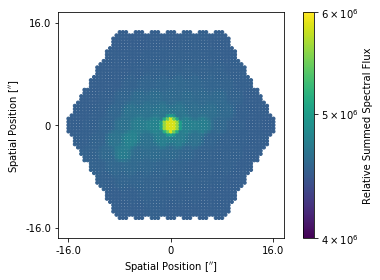

'plt.scatter(X,Y, c=np.sum(regrid_sum, axis=1))\nplt.show()'

In [37]:

print((regrid_sum[30]))
print(len(X))

#masked_regrid_sum = np.ma.masked_where(regrid_sum==0.0, regrid_sum)
#normed_regrid_sum=[(x-min(masked_regrid_sum))/(max(masked_regrid_sum)-min(masked_regrid_sum)) for x in masked_regrid_sum]


plt.clf()

fig=plt.figure()
ax1=fig.add_subplot(111,aspect='equal')
im1=ax1.scatter(X, Y, c=regrid_sum, s=10, norm=LogNorm(vmin=4*10**6, vmax=6*10**6))
cbar1=plt.colorbar(im1,label='Relative Summed Spectral Flux')
#plt.scatter(X, Y, color='black')

#plt.xlim([0,300])
#plt.ylim([0,300])

'''for x in range(len(line_horiz)):
    ax1.axhline(y=line_vert[x], color='black')
    ax1.axvline(x=line_horiz[x], color='black')'''

yticks=[-arc_to_pix(half_extent)+cen_y, cen_y, cen_y+arc_to_pix(half_extent)]
ylabels=[-half_extent, 0, half_extent]
ax1.set_yticks(yticks)
ax1.set_yticklabels(ylabels)

xticks=[-arc_to_pix(half_extent)+cen_x, cen_x, cen_x+arc_to_pix(half_extent)]
xlabels=[-half_extent, 0, half_extent]
ax1.set_xticks(xticks)
ax1.set_xticklabels(xlabels)
ax1.set_ylabel(r'Spatial Position [$^{\prime \prime}$]')
ax1.set_xlabel(r'Spatial Position [$^{\prime \prime}$]')
plt.tight_layout()


#plt.colorbar()
plt.show()
#savefig('Convo_complete_127.pdf')
'''plt.scatter(X,Y, c=np.sum(regrid_sum, axis=1))
plt.show()'''

In [83]:

def arc_to_pix(arc):
    return (arc*(kpc_arcmin.value/60))/pixelscale

def plotting_fibers_r_e(n_fibers, xmin, xmax, ymin, ymax, spacing, radius, correction):
    
    '''input is the effective radius
    1) Convert r_e to arcsec
    2) Determine which fiber to use'''
    if n_fibers==7:
        index_1=[-1,0]
        index_2=[1,1]
        index_3=[3,2]
    
    if n_fibers==19:
        index_1=[-2,-1,-1]
        index_2=[2,2,1]
        index_3=[5,4,3]
    
    if n_fibers==37:
        index_1=[-3,-2,-2,-1]
        index_2=[3,3,2,2]
        index_3=[7,6,5,4]
    
    if n_fibers==61:
        index_1=[-4,-3,-3,-2,-2]
        index_2=[4,4,3,3,2,2]
        index_3=[9,8,7,6,5]
    
    if n_fibers==91:
        xs_0=[-5,5,11]
        xs_1=[-4,5,10]
        xs_2=[-4,4,9]
        xs_3=[-3,4,8]
        xs_4=[-3,3,7]
        xs_5=[-2,3,6]
        
        '''Converting into a better format'''
        index_1=[-5,-4,-4,-3,-3,-2]
        index_2=[5,5,4,4,3,3]
        index_3=[11,10,9,8,7,6]

    if n_fibers==127:
        index_1=[-6,-5,-5,-4,-4,-3,-3]
        index_2=[6,6,5,5,4,4,3]
        index_3=[13,12,11,10,9,8,7]
    

    x_coords=[]
    y_coords=[]
    for i in range(len(index_1)):
        xs=np.linspace(index_1[i],index_2[i],index_3[i])
        xs=np.array(xs)
        if i % 2 == 0:#n % 2 == 0
                #in other words, if its an odd index you need to play with spacing
            
            corr=0   
        else:
            
            corr=radius+correction
        
        for k in range(len(xs)):
            if i==0:#this is to only plot once for the middle row
              
                rect = patches.Circle((xmin+(xmax-xmin)+xs[k]*spacing-corr,ymin+i*np.sin(math.radians(60))*spacing),arc_to_pix(1),linewidth=1,edgecolor='white',facecolor='none')
                ax1.add_patch(rect)
                x_coords.append(xmin+(xmax-xmin)+xs[k]*spacing-corr)
                y_coords.append(ymin+i*np.sin(math.radians(60))*spacing)
            else:
                rect = patches.Circle((xmin+(xmax-xmin)+xs[k]*spacing-corr,ymin+i*np.sin(math.radians(60))*spacing),arc_to_pix(1),linewidth=1,edgecolor='white',facecolor='none')
                #if (xrows[2]-xsub)/2 == 0:#in other words, if its odd
                ax1.add_patch(rect)
                x_coords.append(xmin+(xmax-xmin)+xs[k]*spacing-corr)
                y_coords.append(ymin+i*np.sin(math.radians(60))*spacing)
                rect = patches.Circle((xmin+(xmax-xmin)+xs[k]*spacing-corr,ymin-i*np.sin(math.radians(60))*spacing),arc_to_pix(1),linewidth=1,edgecolor='white',facecolor='none')
                #if (xrows[2]-xsub)/2 == 0:#in other words, if its odd
                ax1.add_patch(rect)
                x_coords.append(xmin+(xmax-xmin)+xs[k]*spacing-corr)
                y_coords.append(ymin-i*np.sin(math.radians(60))*spacing)
    '''I'd also like to plot a huge line scale for the full diameter of the packet (in kpc and "?)'''
    #ax1.axhline(y=ymin+(len(index_1)+2)*np.sin(math.radians(60))*spacing,xlim=(xmin+(xmax-xmin)+index_1[0]*spacing,xmin+(xmax-xmin)+index_2[0]*spacing), color='white', lw=2)
    from matplotlib import collections  as mc

    lines = [[(xmin+(xmax-xmin)+index_1[0]*spacing-radius-arc_to_pix(0.25),ymin+(len(index_1)+1)*np.sin(math.radians(60))*spacing),(xmin+(xmax-xmin)+index_2[0]*spacing+radius+arc_to_pix(0.25),ymin+(len(index_1)+1)*np.sin(math.radians(60))*spacing)]]
    
    #lines = [[(xmin+(xmax-xmin)+index_1[0]*spacing-radius,ymin),(xmin+(xmax-xmin)+index_2[0]*spacing+radius,ymin)]]
    
    length=(xmin+(xmax-xmin)+index_2[0]*spacing+radius+arc_to_pix(0.25))-(xmin+(xmax-xmin)+index_1[0]*spacing-radius-arc_to_pix(0.25))
    '''This is a length in pixels'''
    length_kpc=length*pixelscale
    '''Now its in kpc'''
    length_arc=length_kpc/(kpc_arcmin.value/60)
    ax1.annotate(str(round(length_arc,1))+r'$^{\prime\prime}$',xy=(xmin+(xmax-xmin)+index_1[0]*spacing-radius,ymin+(1.5*len(index_1))*np.sin(math.radians(60))*spacing),xycoords='data', size=15, color='white')
    
    lc = mc.LineCollection(lines, colors='white', linewidths=2)
    
    ax1.add_collection(lc)
    
    
    #plt.segments(x0=xmin+(xmax-xmin)+index_1[0]*spacing,x1=xmin+(xmax-xmin)+index_2[0]*spacing,y0=ymin+(len(index_1)+2)*np.sin(math.radians(60))*spacing)
    return x_coords, y_coords, length_arc
    

In [6]:
def extract_spec_one( xpoint, ypoint):
    
    plt.clf()
    '''This one is going to extract spectra and then convolve them with a Gaussian Kernal
    with resolution 72 km/s'''
    '''Also convolves with a Gaussian'''
    
    
    x_coords = xpoint
    y_coords = ypoint
    new_cube = CAMERA0.data[:,xpoint,ypoint]
    
    

    integrated=new_cube
    
    
    res=[x/2000 for x in Ang]
    
    
    
    g = Gaussian1DKernel(np.mean(res))

    # Convolve data
    z = convolve(integrated, g, boundary='extend')
    
   
    #savefig('pyplots_q0.5_fg0.3_allrx10/extract_fiber.pdf')
    
    #image=CAMERA0.data[:,center_x-]
    #rect = patches.Circle((xmin+(xmax-xmin)+xs[k]*spacing-corr,ymin+i*np.sin(math.radians(60))*spacing),arc_to_pix(1),linewidth=2,edgecolor='white',facecolor='none')
    #            ax1.add_patch(rect)
    
    plt.plot(Ang,integrated)
    plt.xlim([4800,5200])
    #plt.axhline(y=np.mean(res))
    plt.show()
    
    plt.plot(Ang, z)
    plt.xlim([4800,5200])
    plt.show()
    
    return Ang, integrated, z

def extract_spec_x( xmax, ymin, factor):
    
    '''If the length divided by the factor is not an integer stop everything!'''
    
    
    plt.clf()
    
    
    if ((len(CAMERA0.data[0,:,0])/factor).is_integer()):
        length=int(len(CAMERA0.data[0,:,0])/factor)
    else:
        stop
    
    
    data_new = np.zeros((len(CAMERA0.data[:,0,0]), length, length))
    
    
    '''plt.imshow(np.sum(CAMERA0.data, axis=0),norm=LogNorm(vmin=0.001, vmax=10**5))
    plt.colorbar()
    plt.show()'''
    
    
   
    data_new += CAMERA0.data[:, ::factor, ::factor] + CAMERA0.data[:, 1::factor, ::factor] + CAMERA0.data[:, ::factor, 1::factor] + CAMERA0.data[:, 1::factor, 1::factor]# Take (0,0)
    #data_new += CAMERA0.data[:, 1::2, ::2]  # Take (1,0)
    #data_new += CAMERA0.data[:, ::2, 1::2]  # Take (0,1)
    #data_new += CAMERA0.data[:, 1::2, 1::2] # Take (1,1)
    print('~~~~')
    
    plt.imshow(np.sum(data_new, axis=0),norm=LogNorm(vmin=0.001, vmax=10**5))
    plt.colorbar()
    plt.show()
    
    
    '''plt.plot(CAMERA0.data[:,0,0]+CAMERA0.data[:,0,1]+CAMERA0.data[:,1,0]+CAMERA0.data[:,1,1])
    plt.show()
    
    
    
    plt.plot(data_new[:,0,0])
    plt.show()'''
    return data_new


def extract_spec( xmax, ymin, rad):
    
    plt.clf()
    '''This one is going to extract spectra and then convolve them with a Gaussian Kernal
    with resolution 72 km/s'''
    '''Also convolves with a Gaussian'''
    center_x=xmax
    center_y=ymin
    
    radius = arc_to_pix(rad)
    
    '''Step 1: Make a new image of just that spec'''
    #np.sum(CAMERA0.data[:,xmin:xmax,ymin:ymax],axis=0)
    x_coords=[]
    y_coords=[]
    new_cube=[]
    '''create an empty masked array'''
    mask_2d=np.zeros((len(CAMERA0.data[:,0,0]),len(CAMERA0.data[0,:,0]),len(CAMERA0.data[0,0,:])))

    #    masked_stel_vel=ma.masked_where((1/np.sqrt(data_stel_vel_ivar)) > 100 , data_stel_vel)
    for i in range(len(CAMERA0.data[0,:,0])):
        for j in range(len(CAMERA0.data[0,0,:])):
            if (center_x-i)**2+(center_y-j)**2 < radius**2:
                x_coords.append(i)
                y_coords.append(j)
                new_cube.append(CAMERA0.data[:,i,j])
                
            else:
                mask_2d[:,j,i]=1
    masked_cube= np.ma.masked_array(CAMERA0.data[:,:,:], mask=mask_2d)
    plt.imshow(np.sum(masked_cube,axis=0), interpolation='None', vmin=0, vmax=1e4)
    plt.xlim([center_x-10,center_x+10])
    plt.ylim([center_y-10,center_y+10])
    plt.colorbar()
    plt.show()
    
    plt.clf()

    integrated=np.sum(masked_cube,axis=(1,2))
    
    #def arc_to_pix(arc):
    #return (arc*(kpc_arcmin.value/60))/pixelscale
    '''resolution is 2000'''
    res=[x/2000 for x in Ang]
    
    
    
    g = Gaussian1DKernel(np.mean(res))

    # Convolve data
    z = convolve(integrated, g, boundary='extend')
    
   
    #savefig('pyplots_q0.5_fg0.3_allrx10/extract_fiber.pdf')
    
    #image=CAMERA0.data[:,center_x-]
    #rect = patches.Circle((xmin+(xmax-xmin)+xs[k]*spacing-corr,ymin+i*np.sin(math.radians(60))*spacing),arc_to_pix(1),linewidth=2,edgecolor='white',facecolor='none')
    #            ax1.add_patch(rect)
    
    plt.plot(Ang,integrated)
    plt.xlim([4800,5200])
    #plt.axhline(y=np.mean(res))
    plt.show()
    
    plt.plot(Ang, z)
    plt.xlim([4800,5200])
    plt.show()
    
    return Ang, integrated, z

def arc_to_pix(arc):
    return (arc*(kpc_arcmin.value/60))/pixelscale



In [ ]:
'''create a loop to find the stellar velocity at all points'''
xmin=150
xmax=200
ymin=175
ymax=225

os.chdir(os.path.expanduser('~/Documents/LAURA_SIMS'))
print(os.getcwd())
#os.chdir(os.path.expanduser('~/Documents/LAURA_Sims/'))

stell_vel = np.zeros((len(CAMERA0.data[0,:,0]),len(CAMERA0.data[0,0,:])))
stell_vel_e = np.zeros((len(CAMERA0.data[0,:,0]),len(CAMERA0.data[0,0,:])))
stell_disp = np.zeros((len(CAMERA0.data[0,:,0]),len(CAMERA0.data[0,0,:])))
stell_disp_e = np.zeros((len(CAMERA0.data[0,:,0]),len(CAMERA0.data[0,0,:])))
#for i in range(len(CAMERA0.data[0,:,0])):
#    for j in range(len(CAMERA0.data[0,0,:])):
for i in range(1):#was 20
    for j in range(1):   
        xs=190+i
        ys=165+j
        y=extract_spec(xs,ys,0.5) #was 0.01
        x=y[0]
        spec_non_convolved=y[1]
        spec_convolved=y[2]
        
        '''plt.plot(x,spec_non_convolved, label='non-convolved')
        plt.legend()
        plt.show()
        plt.plot(x,y[2], label='convolved')
        plt.legend()
        plt.show()'''

        #y=ppxf_from_J1354(x, spec_non_convolved,'no', 1, 0.04,0,0.01)
        
        
        
        
        c = 299792.458*1000#to get into m/s


        pixelscale=0.166666#kpc/pix/

        d_lum = cosmo.luminosity_distance(0.03).value 

        Janskies=np.array(10**(26)*spec_convolved*(pixelscale/(1000*d_lum))**2*np.pi*((6185.2*10**(-10))**2/c), dtype='>f4')
        #A Jansky is 10−26 watts per square metre per hertz.

        f_lambda=np.array(10**17*(10**7*spec_non_convolved*(pixelscale/(1000*d_lum))**2)/(100**2*10**10))
        #should give the flux density in units of erg cm^-2, s^-1, A^-1
        
        '''plt.plot(Ang[1000:1500], f_lambda[1000:1500])
        plt.ylabel(r'F$_{\mathrm{\lambda}}$ [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]')
        plt.title('SDSS units')
        plt.show()'''

        nanomaggy=Janskies/(3.631*10**(-6))
        
        counts=nanomaggy/1367.29546
        
        sky_resids_mine=np.random.normal(0.01955593,0.0042225,len(nanomaggy))
        poisson_plus = np.sqrt((np.flipud(nanomaggy)+ 0.004701377)/1367.29546)+sky_resids_mine
        poisson_plus_nanomags = poisson_plus*1367.29546
        
        
        
        
        c=2.99792458e5
        #we need to convert to counts so we can extract
        #an error spectrum
        
        plt.plot(x, spec_non_convolved, label='Input MilesHC')
        plt.plot(x, np.sqrt(spec_non_convolved), label='Error MILESHC')
        plt.legend()
        plt.show()
        y=ppxf_mileshc_nonvis(x,spec_non_convolved,np.sqrt(spec_non_convolved),5,'yes',0,'yes',8,-1,0,0,0, c*np.log(1 + 0.0),  100, 2)
        
        #y=ppxf_mileshc(x,spec_non_convolved,np.sqrt(spec_non_convolved),5,'yes',0,'yes',8,-1,0,0,0, c*np.log(1 + 0.03),  100, 2)
        '''also calculate the redshift from this'''

        #print('y output', y)
        z_input=0.0
        
        red_vel_input=c*np.log(1 + z_input)
        
        z_stars=np.exp( y[2]     /c)-1

        stell_vel[xs,ys]=(y[2]-red_vel_input)/(1+z_stars)
        
        print('stellar velocity offset', (y[2]-red_vel_input)/(1+z_stars))
        #stell_vel_e[xs,ys]=abs((y[2]/y[3])*((y[3]-red_vel_input)/(1+z_stars)))
        stell_vel_e[xs,ys]=(y[4])
        stell_disp[xs,ys]=y[3]
        stell_disp_e[xs,ys]=y[5]
        #this is the percent error multiplied by the corrected stellar velocity
        
  
    


/Users/beckynevin/Documents/LAURA_SIMS
The history saving thread hit an unexpected error (OperationalError('unable to open database file',)).History will not be written to the database.


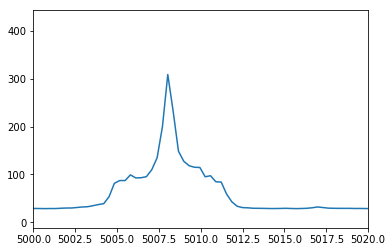

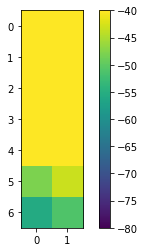

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [ ]:
'''The output is the stellar velocity, so we will need to save a file
so that we can input it into kinemetry directly'''
'''Reuse the kinemetry input method from your earlier work with MaNGA'''

In [11]:
'''This is the type of ppxf that replicates the results for MaNGA'''
def ppxf_mileshc_nonvis(t,flux,noise,vr, plot, bs, conv, dg, mdg, regularization, redo_noise, last_chi,input_vel, input_sig, mom ):

    file_dir = '../ppxf'  # path of this procedure
    c=2.99792458e5
    input_z=np.exp( input_vel     /c)-1
    print('input vel', input_vel)

 
    t=np.array(t)
    flux=np.array(flux)
    noise=np.array(noise)
        
        
    
    '''step 2: Mask with the other mask to restrict wavelengths'''
    mask_2 =  (t < 7409) & (t > 3540)
    
    flux=flux[mask_2]
    t=t[mask_2]
    noise=noise[mask_2]
   

    
    
    var_scaled = noise
    galaxy = flux   
    if regularization!=0:
        #TEMPLATES/=np.median(TEMPLATES))
        galaxy/=np.median(galaxy)
    #apparently we don't need the normalization
    #/np.median(flux)   # Normalize spectrum to avoid numerical issues

    
    loglam_gal = np.log(t)
    lam_gal = t
    
    #lam_gal *= np.median(util.vac_to_air(lam_gal)/lam_gal)

    
    if redo_noise == 0:
        noise = var_scaled
    else:
        noise = var_scaled*np.sqrt(last_chi)

    c = 299792.458                  # speed of light in km/s
    frac = lam_gal[1]/lam_gal[0]    # Constant lambda fraction per pixel

    dlam_gal = (frac - 1)*lam_gal   # Size of every pixel in Angstrom
  
    xs=np.linspace(0,len(lam_gal)-1,len(lam_gal))
    fwhm_gal = [(2.355*(lam_gal[x]))/2000 for x in xs] # Resolution FWHM of every pixel, in Angstroms
    
    #resolution is 2000
    #
    
    x_1=np.linspace(0,len(lam_gal)-2,len(lam_gal)-1)
    fwhm_gal=[2.355*(lam_gal[x+1]-lam_gal[x]) for x in x_1]
    fwhm_gal.append(fwhm_gal[len(x_1)-1])
    fwhm_gal=np.array(fwhm_gal)
    
    
    velscale = np.log(frac)*c       # Constant velocity scale in km/s per pixel
    
    
    #file_dir = glob.glob('miles_models/Mun*.fits')
    file_dir = glob.glob('../ppxf/indo_us/IRAF/*.fits')
    #file_dir = glob.glob('../MaNGA_code/practice_logcube/DAP/data/spectral_templates/miles_cluster/*.fits')

    print(len(file_dir))

    hdu = pyfits.open(file_dir[0])
    ssp = hdu[0].data
    h2 = hdu[0].header
    
    lam_temp = h2['CRVAL1'] + h2['CDELT1']*np.arange(h2['NAXIS1'])
    lamRange_temp = [np.min(lam_temp), np.max(lam_temp)]
    sspNew_1 = util.log_rebin(lamRange_temp, ssp, velscale=velscale/vr)[0]
    
    
    lam_gal_plot = lam_gal/(1+input_z)
    
    
    templates = np.empty((sspNew_1.size, len(file_dir)))
    
    fwhm_tem = 2.5

    # Interpolates the galaxy spectral resolution at the location of every pixel
    # of the templates. Outside the range of the galaxy spectrum the resolution
    # will be extrapolated, but this is irrelevant as those pixels cannot be
    # used in the fit anyway.
    fwhm_gal = np.interp(lam_temp, lam_gal, fwhm_gal)
    
    
    #print('fwhm_gal', fwhm_gal)
    # Convolve the whole Vazdekis library of spectral templates
    # with the quadratic difference between the SDSS and the
    # Vazdekis instrumental resolution. Logarithmically rebin
    # and store each template as a column in the array TEMPLATES.

    # Quadratic sigma difference in pixels Vazdekis --> SDSS
    # The formula below is rigorously valid if the shapes of the
    # instrumental spectral profiles are well approximated by Gaussians.
    #
    # In the line below, the fwhm_dif is set to zero when fwhm_gal < fwhm_tem.
    # In principle it should never happen and a higher resolution template should be used.
    #
    fwhm_dif = np.sqrt((fwhm_gal**2 - fwhm_tem**2).clip(0))
    sigma = fwhm_dif/2.355/h2['CDELT1'] # Sigma difference in pixels

    for j, fname in enumerate(file_dir):
        hdu = pyfits.open(fname)
        ssp = hdu[0].data
        '''if j==0 and plot=='yes':
            plt.plot(lam_temp, ssp, label='Pre Convolved')'''
        if conv=='yes':
            ssp = util.gaussian_filter1d(ssp, sigma)  # perform convolution with variable sigma
        
        sspNew = util.log_rebin(lamRange_temp, ssp, velscale=velscale/vr)[0]
        templates[:, j] = sspNew/np.median(sspNew) # Normalizes templates
    
   
    
    c = 299792.458
    dv = np.log(lam_temp[0]/lam_gal[0])*c    # km/s
    
    #z=0
    '''goodpix also have to be adjusted for the redshift'''
    goodpixels = util.determine_goodpixels(np.log(lam_gal), lamRange_temp, input_z)
    
    vel = c*np.log(1 + input_z)   # Initial estimate of the galaxy velocity in km/s
    
    start = [input_vel, input_sig]  # (km/s), starting guess for [V, sigma]
    #start = [0,200]
    t = clock()
    if regularization !=0:
        templates/=np.median(templates)
        
    if np.any((noise > 0)):
        noise=np.ones(len(galaxy))
        
    pp = ppxf(templates, galaxy, noise, velscale, start,
              goodpixels=goodpixels, bias=bs, plot=True, moments=mom,
              degree=dg,mdegree=mdg, vsyst=dv, velscale_ratio=vr, regul=regularization,
              clean=False)#was degree=12
    print('pp.sol', pp.sol)
    plt.legend()
    # If the galaxy is at significant redshift z and the wavelength has been
    # de-redshifted with the three lines "z = 1.23..." near the beginning of
    # this procedure, the best-fitting redshift is now given by the following
    # commented line (equation 2 of Cappellari et al. 2009, ApJ, 704, L34):
    #
    #print, 'Best-fitting redshift z:', (z + 1)*(1 + sol[0]/c) - 1

#------------------------------------------------------------------------------
    #plt.xlim([6275,6400])
    #plt.ylim([0.8,1.5])
    #plt.ylim([0,1.5])
    #plt.ylim()
    plt.show()
    plt.clf()
    
    if abs(pp.sol[0]) > 1000:
        err = 999
    else:
        err = pp.sol[1]
    return lam_gal, galaxy, pp.sol[0], err,pp.error[0], pp.error[1], pp.chi2
#pp.sol is vel and sig




/Volumes/My Passport for Mac/LAURA_Sims/q0.5_fg0.3_allrx10_sunruns/hirestest_kin
0.6067249692472986 kpc per arcsec


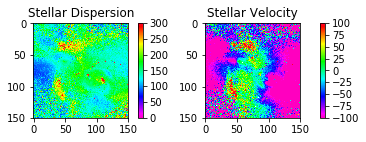

/Users/beckynevin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:68: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


~~~~


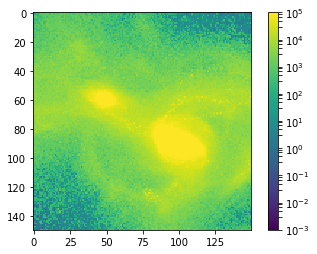

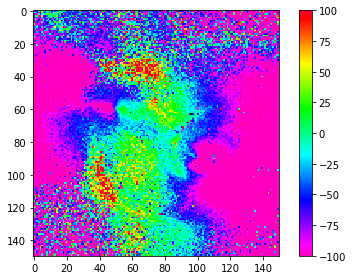

150 150 150


TypeError: tophat_convolve() missing 1 required positional argument: 'size'

In [16]:
plt.clf()
print(os.getcwd())
os.chdir(os.path.expanduser('~/Documents/MMT/'))

#plotting_maps('kinemetry_input/kinemetry_input_100.txt')
#plotting_maps_janky('Figs/logfile_v_4_preserve.out', 150)
plt.clf()
y=plotting_maps_janky('Figs/read.txt', 150)
#plotting_maps_janky('Figs/kinemetry_input_append_6.txt', 30)
#



75 75
75 72


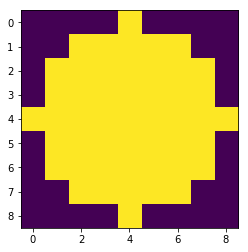

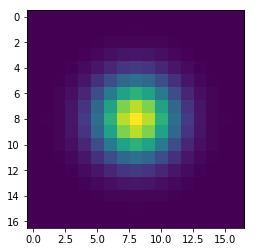

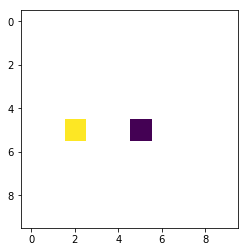

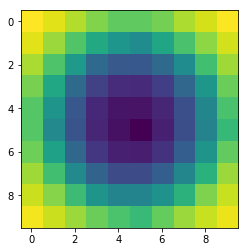

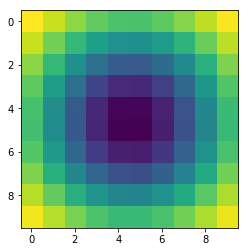

In [53]:
tophat_convolve('Figs/read.txt', 150,4)

In [153]:
k=MaNGAize(y[0], y[1], y[2], y[3], 17.6, y[4])
new_kinemetry(k[0], k[1], k[2], k[3], k[4], k[5])


[[False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]
 ..., 
 [False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]]


In [12]:

def new_kinemetry(masked, masked_e, masked_d, masked_d_e, middle_x, middle_y):
    
    os.chdir(os.path.expanduser('~/Documents/LAURA_Sims/'))

    file2=open('kinemetry_input/kinemetry_masked.txt','w')
    file2.write('#'+'\t'+'XBIN'+'\t'+'YBIN'+'\t'+'VEL'+'\t'+'ER_VEL'+'\t'+'SIG'+'\t'+'ER_SIG'+'\n')
    
    
    counter=1
    for i in range(149):
        for j in range(149):
            if str(masked[i,j])== '--':
                continue
            else:
                file2.write(str(counter)+'\t'+str(i-middle_x)+'\t'+str(j-middle_y)+'\t')
                file2.write(str(round(masked[i,j],2))+'\t'+str(round(masked_e[i,j],2))+'\t'+str(round(masked_d[i,j],2))+'\t'+str(round(masked_d_e[i,j],2))+'\n')
                #print(counter, i, j, masked[i,j])
                counter +=1
                
    file2.close()
    

In [13]:
def MaNGAize(masked_stel_vel, masked_stel_vel_e, masked_stel_disp, masked_stel_disp_e, r_e, pixsize):
    #pixsize=0.5
    if r_e > 17.5:
        fiber=37
        diameter=17.5
        spacing=17
        size=150
        xc=101
        yc=90
        hex_spacing=spacing*math.tan(math.radians(30))
        '''this means 17 pixels on either side of the brightest pixels'''
        
        
    '''Step 1 is to identify where the center of the galaxy is in this new convolved image'''
    #was: xc=202, now 101
    #was: yc=179, now 90
    
    
    '''also create a bitmask'''
    import numpy as np
    from matplotlib.path import Path

    nx, ny = 150, 150
    poly_verts = [(xc-spacing, yc), (xc-hex_spacing,yc-spacing),(xc+hex_spacing,yc-spacing), (xc+spacing, yc), (xc+hex_spacing,yc+spacing), (xc-hex_spacing,yc+spacing),(xc-spacing, yc)]

    # Create vertex coordinates for each grid cell...
    # (<0,0> is at the top left of the grid in this system)
    x, y = np.meshgrid(np.arange(nx), np.arange(ny))
    x, y = x.flatten(), y.flatten()

    points = np.vstack((x,y)).T

    path = Path(poly_verts)
    grid = path.contains_points(points)
    grid = grid.reshape((ny,nx))


    print(grid)
    
    second_mask=ma.masked_where(grid==False, masked_stel_vel)
    second_mask_e=ma.masked_where(grid==False, masked_stel_vel_e)
    second_mask_disp=ma.masked_where(grid==False, masked_stel_disp)
    second_mask_disp_e=ma.masked_where(grid==False, masked_stel_disp_e)
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111, aspect='equal')
    #im1 = ax1.contour(X, Y, Z, levels, colors='black', linewidths=1)
    
    #[yc-spacing:yc+spacing,xc-spacing:xc+spacing]
    
    
    im2 = ax1.imshow(((second_mask[yc-spacing:yc+spacing,xc-spacing:xc+spacing])), vmin=-150, vmax=150, cmap='gist_rainbow_r', alpha=0.75)
    plt.colorbar(im2, orientation='vertical', label='Stellar Velocity')
    #plt.scatter(xc, yc, color='red', s=100)
    #fig.tight_layout()
    '''yticks=[0 ,size/2    ,size]
    ylabels=[round((x-size/2)*pixsize,1) for x in yticks]
    ax1.set_yticks(yticks)
    ax1.set_yticklabels(ylabels)
    ax1.set_xticks(yticks)
    ax1.set_xticklabels(ylabels)
    ax1.set_ylabel(r'Spatial Position [$^{\prime \prime}$]')
    ax1.set_xlabel(r'Spatial Position [$^{\prime \prime}$]')'''
    #plt.tight_layout()
    plt.savefig('../MaNGA_papers/Paper_I/stel_vel_overlay_MaNGA.pdf')
    
    return second_mask, second_mask_e, second_mask_disp, second_mask_disp_e, yc, xc

In [52]:
def tophat_convolve(file_path, size, size2):
    #First, break down the kinemetry file
    
    with open(file_path, 'r') as f:
        data = f.readlines()
        #print(data)
        stel_vel=np.zeros((size,size))
        stel_vel_e=np.zeros((size,size))
        stel_disp=np.zeros((size,size))
        stel_disp_e=np.zeros((size,size))
        
        
        for line in data:
            words = line.split()
            
 
            if (words[0]) == '75':
                if words[1] =='72' or words[1] =='75':
                    print(words[0], words[1])

                    xs=int(round(float(words[0]),0))
                    ys=int(round(float(words[1]),0))

                    '''if float(words[2]) != 0 and float(words[4]) != 0:

                        if abs(float(words[3])/float(words[2])) < 10 and abs(float(words[5])/float(words[4])) < 10:
                         '''   

                    stel_vel[xs,ys] = float(words[2])
                    stel_vel_e[xs,ys] = float(words[3])

                    stel_disp[xs,ys] = float(words[4])
                    stel_disp_e[xs,ys] = float(words[5])
                
                
                
                

    #masked_stel_vel=np.ma.masked_where(abs(stel_vel_e/stel_vel) > 1, stel_vel)
    masked_stel_vel = np.ma.masked_where(stel_vel == 0, stel_vel)
    masked_stel_vel_e = np.ma.masked_where(stel_vel==0, stel_vel_e)
    
    #masked_disp = np.ma.masked_where(abs(stel_disp_e/stel_disp) > 1, stel_disp)
    masked_disp = np.ma.masked_where(stel_disp ==0, stel_disp)
    masked_disp_e = np.ma.masked_where(stel_disp==0, stel_disp_e)
    
    
    #class astropy.convolution.Tophat2DKernel(radius, **kwargs)[source] [edit on github]
    '''so pixels are 0.5" and we need a 2.0" diameter kernel'''
    top=Tophat2DKernel( size2)
    plt.imshow(top)
    plt.show()
    
    gauss=Gaussian2DKernel(5/2.355)#input is std 2.355*sig = FWHM so FWHm/2.355
    #each pixel is 0.5" so a 2.5" FWHM is actually 5 pixels
    
    plt.imshow(gauss)
    plt.show()
    
    plt.imshow(masked_stel_vel[70:80,70:80])
    plt.show()
    
    '''Now, actually convolve it :)'''
    fiber = convolve(masked_stel_vel[70:80,70:80], top)
    psf = convolve(fiber, gauss)
    plt.imshow(fiber)
    plt.show()
    
    plt.imshow(psf)
    plt.show()

In [15]:
def plotting_maps_janky(file_path, size):
    #First, break down the kinemetry file
    
    with open(file_path, 'r') as f:
        data = f.readlines()
        #print(data)
        stel_vel=np.zeros((size,size))
        stel_vel_e=np.zeros((size,size))
        stel_disp=np.zeros((size,size))
        stel_disp_e=np.zeros((size,size))
        
        
        for line in data:
            words = line.split()
 
            if (words[0]) != 'Beginning':
 
             
                xs=int(round(float(words[0]),0))
                ys=int(round(float(words[1]),0))
            
                '''if float(words[2]) != 0 and float(words[4]) != 0:
            
                    if abs(float(words[3])/float(words[2])) < 10 and abs(float(words[5])/float(words[4])) < 10:
                     '''   

                stel_vel[xs,ys] = float(words[2])
                stel_vel_e[xs,ys] = float(words[3])

                stel_disp[xs,ys] = float(words[4])
                stel_disp_e[xs,ys] = float(words[5])
                
                
                
                

    #masked_stel_vel=np.ma.masked_where(abs(stel_vel_e/stel_vel) > 1, stel_vel)
    masked_stel_vel = np.ma.masked_where(stel_vel == 0, stel_vel)
    masked_stel_vel_e = np.ma.masked_where(stel_vel==0, stel_vel_e)
    
    #masked_disp = np.ma.masked_where(abs(stel_disp_e/stel_disp) > 1, stel_disp)
    masked_disp = np.ma.masked_where(stel_disp ==0, stel_disp)
    masked_disp_e = np.ma.masked_where(stel_disp==0, stel_disp_e)
    '''plt.imshow(np.fliplr(np.flipud(masked_stel_vel)), vmin=-150, vmax=150)
    plt.colorbar()
    plt.show()
    plt.clf()
    '''
    '''What about making it look pretty with pixelsize?'''
    
    kpc_arcmin=cosmo.kpc_proper_per_arcmin(0.03)#insert the redshift  
    #MaNGA's pixels are 0.5 arcseconds
    print(kpc_arcmin.value/60, 'kpc per arcsec')
    pixelscale=0.16666
    
    pixsize = pixelscale / (kpc_arcmin.value/60)
    
    '''Make labels'''
    fig = plt.figure()
    ax1 = fig.add_subplot(211, aspect='equal')
    ax1.set_title('Stellar Velocity')
    
    im1=ax1.imshow(((masked_stel_vel)), vmin=-100, vmax=100, cmap='gist_rainbow_r')
    
    yticks=[0,75,150,150+75,300]
    yticks=[0 ,size/2    ,size]
    ylabels=[round((x-size/2)*pixsize,1) for x in yticks]
    #ax1.set_yticks(yticks)
    #ax1.set_yticklabels(ylabels)
    #ax1.set_xticks(yticks)
    #ax1.set_xticklabels(ylabels)
    #ax1.set_ylabel(r'Spatial Position [$^{\prime \prime}$]')
    #ax1.set_xlabel(r'Spatial Position [$^{\prime \prime}$]')
    plt.colorbar(im1, orientation='vertical')
    
    ax2 = fig.add_subplot(221, aspect='equal')
    ax2.set_title('Stellar Dispersion')
    
    im2=ax2.imshow(((masked_disp)), vmin=0, vmax=300, cmap='gist_rainbow_r')
    
    yticks=[0,75,150,150+75,300]
    yticks=[0 ,size/2    ,size]
    ylabels=[round((x-size/2)*pixsize,1) for x in yticks]
    #ax1.set_yticks(yticks)
    #ax1.set_yticklabels(ylabels)
    #ax1.set_xticks(yticks)
    #ax1.set_xticklabels(ylabels)
    #ax1.set_ylabel(r'Spatial Position [$^{\prime \prime}$]')
    #ax1.set_xlabel(r'Spatial Position [$^{\prime \prime}$]')
    plt.colorbar(im2, orientation='vertical')
    fig.tight_layout()
    plt.show()
    
    
    y=extract_spec_x(190, 165 ,300/size)
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111, aspect='equal')
    im1 = ax1.imshow(np.sum(y, axis=0),norm=LogNorm(vmin=0.001, vmax=10**5), alpha=0.9, cmap='Greys')
    im2 = ax1.imshow(((masked_stel_vel)), vmin=-100, vmax=100, cmap='gist_rainbow_r')
    plt.colorbar(im2, orientation='vertical')
    fig.tight_layout()
    plt.show()
    
    
    x = np.arange(0, size, 1)
    y1 = np.arange(0, size, 1)
    
    X, Y = np.meshgrid(x, y1)
    
    Z = np.array(np.sum(y, axis=0))
    
    
    
    print(len(X), len(Y), len(Z))
    levels = np.arange(10**4, 10**5.5, 10**5)
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111, aspect='equal')
    im1 = ax1.contour(X, Y, Z, levels, colors='black', linewidths=1)
    
    
    im2 = ax1.imshow(((masked_stel_vel)), vmin=-150, vmax=150, cmap='gist_rainbow_r', alpha=0.75)
    plt.colorbar(im2, orientation='vertical', label='Stellar Velocity')
    #fig.tight_layout()
    yticks=[0 ,size/2    ,size]
    ylabels=[round((x-size/2)*pixsize,1) for x in yticks]
    ax1.set_yticks(yticks)
    ax1.set_yticklabels(ylabels)
    ax1.set_xticks(yticks)
    ax1.set_xticklabels(ylabels)
    ax1.set_ylabel(r'Spatial Position [$^{\prime \prime}$]')
    ax1.set_xlabel(r'Spatial Position [$^{\prime \prime}$]')
    #plt.tight_layout()
    plt.savefig('../MaNGA_papers/Paper_I/stel_vel_overlay.pdf')
    
    
    return masked_stel_vel, masked_stel_vel_e, masked_disp, masked_disp_e, pixsize
    

In [154]:
sim_vel=[   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
      -46.695433
,
      -58.116705
,
      -72.935725
,
      -90.550350
,
      -108.29545
,
      -121.70866
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
      -36.496899
,
      -44.227384
,
      -58.281784
,
      -67.781490
,
      -86.234827
,
      -107.29158
,
      -127.38417
,
      -147.80536
,
      -158.95874
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
      -39.943361
,
      -48.570254
,
      -52.146510
,
      -61.032175
,
      -87.441315
,
      -112.73169
,
      -135.25647
,
      -154.62976
,
      -170.46129
,
      -182.92507
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
      -46.567064
,
      -54.341513
,
      -58.244652
,
      -71.427209
,
      -102.81159
,
      -153.72000
,
      -155.36577
,
      -168.65659
,
      -178.65317
,
      -196.08297
,
      -194.48458
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
      -63.314594
,
      -70.805729
,
      -82.546254
,
      -103.22215
,
      -127.06503
,
      -153.30078
,
      -181.10006
,
      -184.16687
,
      -201.71317
,
      -202.84026
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
      -85.294560
,
      -96.194262
,
      -108.82326
,
      -129.48277
,
      -150.25745
,
      -167.61059
,
      -187.90996
,
      -205.95474
,
      -204.91383
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
      -120.54605
,
      -142.22523
,
      -159.69546
,
      -177.76230
,
      -188.85352
,
      -194.29819
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08
,
   1.2345679e+08]

913
1089


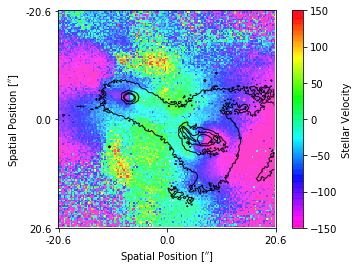

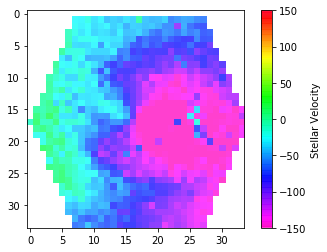

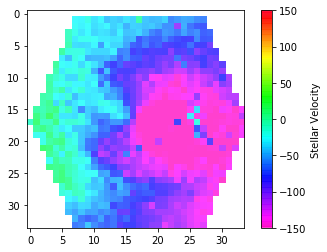

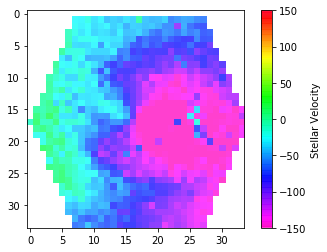

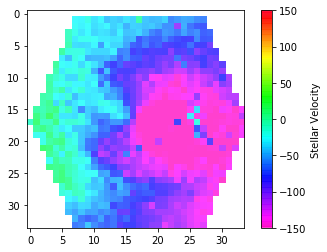

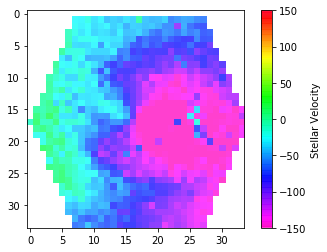

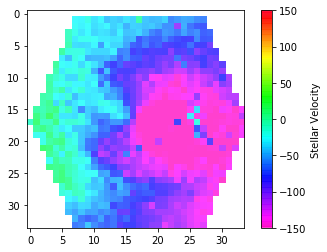

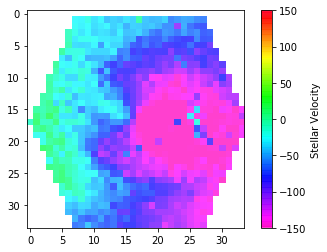

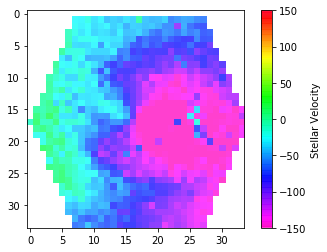

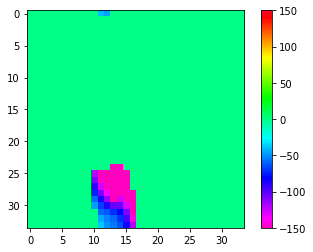

In [155]:
n=0
print(len(sim_vel))
print(33*33)
sim_vel_stars=np.zeros(shape=(34,34))
for j in range(34):
    for k in range(34):
        
       
            
        xbin_corr=j
        ybin_corr=k


        #print(n)
        try:
            sim_vel_stars[ybin_corr][xbin_corr]=sim_vel[n]
            if sim_vel[n] > 40000:
                sim_vel_stars[ybin_corr][xbin_corr]=0
            
            n+=1
        except IndexError:
            n+=1 
            continue
plt.clf()
plt.imshow(np.flipud(sim_vel_stars), vmin=-150, vmax=150,cmap='gist_rainbow_r')
plt.colorbar()
plt.show()

In [204]:
file_in='kinemetry_out/myfile.txt'
file_in='kinemetry_out/myfile_v.txt'
with open (file_in, 'r') as f:
    data = f.readlines()
  
    xbin=[]
    ybin=[]
    velbin=[]
    velmod=[]
    for x in data:
        words = x.split()
        xbin.append(float(words[0]))
        ybin.append(float(words[1]))
        velbin.append(float(words[2]))
        if words[6]=='*************************':
            velmod.append(0)
        else:
            velmod.append(float(words[6]))
print(velbin)

[-26.6900005, -27.2399998, -18.9300003, -32.8400002, -27.2800007, -42.5200005, -37.5999985, -40.8300018, -33.8600006, -37.7099991, -0.02, -41.7099991, -45.5499992, -43.9399986, -37.9900017, -59.3899994, -55.0099983, -49.6399994, -50.7700005, -57.4599991, -60.3699989, -23.7600002, -28.1800003, -25.4799995, -35.1199989, -31.4400005, -27.1100006, -38.4000015, -33.1899986, -47.3100014, -37.9199982, -39.7299995, -43.1699982, -40.6899986, -45.9900017, -56.4000015, -56.8499985, -108.2099991, -48.5200005, -65.4300003, -71.6699982, -72.8000031, -8.7700005, -20.4799995, -32.4300003, -26.1499996, -37.0299988, -33.0600014, -34.7099991, -40.0099983, -28.9799995, -42.8800011, -41.9900017, -37.0, -47.2999992, -59.8800011, -66.4700012, -54.9500008, -57.1199989, -64.1900024, -52.2599983, -62.0099983, -56.9799995, -71.3700027, -68.8899994, -7.6700001, -31.2399998, -21.9099998, -21.7299995, -23.6900005, -30.8199997, -30.6200008, -33.3199997, -32.2000008, -46.9900017, -45.5499992, -74.3499985, -64.4800034

-26.6900005
1089


/Users/beckynevin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/beckynevin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


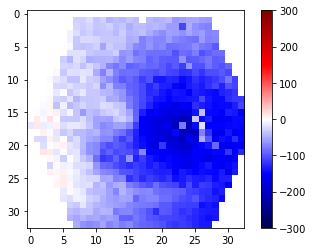

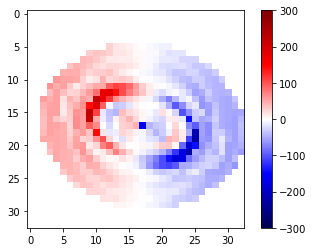

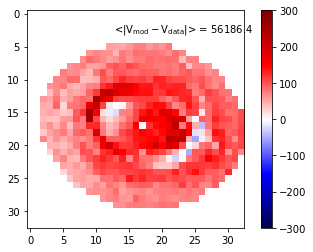

In [206]:
n=0
print(velbin[0])
print(33*33)
sim_vel_stars=np.zeros(shape=(33,33))
sim_mod_stars=np.zeros(shape=(33,33))
for n in range(len(velbin)):
        
       
            
    xbin_corr=xbin[n]+17
    ybin_corr=ybin[n]+17


    #print(n)
    try:
        sim_vel_stars[xbin_corr][ybin_corr]=velbin[n]
        sim_mod_stars[xbin_corr][ybin_corr]=velmod[n]
        if velbin[n] > 40000:
            sim_vel_stars[xbin_corr][ybin_corr]=0
            sim_mod_stars[xbin_corr][ybin_corr]=0

        n+=1
    except IndexError:
        n+=1 
        continue

sim_vel_stars=ma.masked_where(sim_vel_stars==0, sim_vel_stars)
sim_mod_stars=ma.masked_where(sim_mod_stars==0, sim_mod_stars)
plt.clf()


plt.imshow((sim_vel_stars), vmin=-300, vmax=300,cmap='seismic')
plt.colorbar()
plt.show()
plt.imshow((sim_mod_stars), vmin=-300, vmax=300,cmap='seismic')
plt.colorbar()
plt.show()


resid=sim_mod_stars-sim_vel_stars
plt.imshow(resid, vmin=-300, vmax=300,cmap='seismic')
plt.colorbar()
plt.annotate(r'<|V$_{\mathrm{mod}} - \mathrm{V}_{\mathrm{data}}$|> = '+str(round(abs(np.sum(sim_mod_stars-sim_vel_stars)),1)), xy=(0.4,0.9), xycoords='axes fraction')
plt.show()

In [207]:
'''To measure delta PA, just take the standard deviation of the PA from kinemetry'''

'''0th:72.000     0.200     0.000     0.000    20

  1-th radius:     1.050    72.000     0.200     0.000     0.000    21
  2-th radius:     1.605    70.136     0.230     0.000     0.000    32
  3-th radius:     2.166    69.399     0.230     0.000     0.000    43
  4-th radius:     2.732    71.417     0.210     0.000     0.000    54
  5-th radius:     3.305    75.553     0.766     0.000     0.000    66
  6-th radius:     3.886    72.789     0.711     0.000     0.000    77
  7-th radius:     4.474    72.012     0.676     0.000     0.000    89
  8-th radius:     5.072    71.995     0.644     0.000     0.000   100
  9-th radius:     5.679    71.481     0.559     0.000     0.000   100
 10-th radius:     6.297    69.994     0.435     0.000     0.000   100
 11-th radius:     6.927    81.525     0.502     0.000     0.000   100
 12-th radius:     7.569    80.976     0.595     0.000     0.000   100
 13-th radius:     8.226    71.994     0.640     0.000     0.000   100
 14-th radius:     8.899    62.497     0.719     0.000     0.000   100
 15-th radius:     9.589   -93.411     0.937     0.000     0.000   100
 16-th radius:    10.297    94.437     0.857     0.000     0.000   100
 17-th radius:    11.027    91.233     1.000     0.000     0.000   100
 18-th radius:    11.780    90.966     0.995     0.000     0.000   100
 19-th radius:    12.558    71.892     0.525     0.000     0.000   100
 20-th radius:    13.364    67.651     0.456     0.000     0.000   100
 21-th radius:    14.200    81.764     0.897     0.000     0.000   100
 22-th radius:    15.070    81.000     0.840     0.000     0.000   100
 23-th radius:    15.977    83.947     0.691     0.000     0.000   100
 24-th radius:    16.925    63.541 '''
PAs=[72.000, 72.000, 70.136, 69.399, 71.417, 75.553, 72.789, 72.012, 71.995, 
     71.481, 69.994, 81.525, 80.976, 71.994, 62.497, -93.411, 94.437, 91.233,
     90.966, 71.892, 67.651, 81.764, 81.000, 83.947, 63.541]
print(mean(PAs), np.std(PAs))

68.75152 34.0759664023


In [217]:
l=galfit_params(0,200,2)
print(l)

'''So the deviation is actually'''
dev=mean(PAs)-73.8111

err_img=0.1158
err_kin=std(PAs)

print('Error',np.sqrt(err_img**2+err_kin**2))
print('Deviation between PAs', dev)

'''There is an error associated with PA_img but how do we get the kinematic PA error (from std)'''

Sersic indices 2.3287 +/- 0.0055 1.2579 +/- 0.0052
Effective Radius in pixels 32.3205 +/- 0.1114 10.1936 +/- 0.0342
magnitudes 17.3054 +/- 0.0024 18.9581 +/- 0.0019
flux ratio 0.21823278751645153
PAs -73.8111 +/- 0.1158 -77.7747 +/- 0.3191
sep in pix 117.922520146
sep in kpc 19.6536747426
(19.653674742586968, 0.21823278751645153, '-73.8111 +/- 0.1158')
Error 34.0761631627
Deviation between PAs -5.05958


'There is an error associated with PA_img but how do we get the kinematic PA error (from std)'

In [211]:
'''Now open the galfit result and get the effective radius '''
def galfit_params(view,output_number,num_bulges):
    pixelscale=0.166666#kpc/pix
    plt.clf()
    output='GALFIT_folder/out_'+str(view)+'_'+str(output_number)+'.fits'
    out=pyfits.open(output)
    #print(out[2].header)
    #2 is model
    #3 is residual map
    
    if num_bulges==1:
        print('Sersic indices',out[2].header['1_N'])
        print('Effective Radius in pixels',out[2].header['1_RE'])

        print('magnitudes', out[2].header['1_MAG'])
        mag_1=float(out[2].header['1_MAG'][:7])
     

       

        print('PAs', out[2].header['1_PA'])
        PA_kin=out[2].header['1_PA']
        sep=0
        flux_ratio=0

        
    else:
        try:

            print('Sersic indices',out[2].header['1_N'],out[2].header['2_N'])
            print('Effective Radius in pixels',out[2].header['1_RE'],out[2].header['2_RE'])

            print('magnitudes', out[2].header['1_MAG'],out[2].header['2_MAG'])
            mag_1=float(out[2].header['1_MAG'][:7])
            mag_2=float(out[2].header['2_MAG'][:7])

            print('flux ratio', 100**((mag_1-mag_2)/5))
            flux_ratio=100**((mag_1-mag_2)/5)

            print('PAs', out[2].header['1_PA'],out[2].header['2_PA'])
            PA_kin=out[2].header['1_PA']
            # we also need to print out the separation in physical space between the components.
            x_1=float(out[2].header['1_XC'][:7])
            x_2=float(out[2].header['2_XC'][:7])
            y_1=float(out[2].header['1_YC'][:7])
            y_2=float(out[2].header['2_YC'][:7])

            print('sep in pix', np.sqrt(abs(x_1-x_2)**2+abs(y_1-y_2)**2))
            print('sep in kpc', pixelscale*np.sqrt(abs(x_1-x_2)**2+abs(y_1-y_2)**2))
            sep=pixelscale*np.sqrt(abs(x_1-x_2)**2+abs(y_1-y_2)**2)
        except ValueError:
            print('Sersic indices',out[2].header['1_N'])
            print('Effective Radius in pixels',out[2].header['1_RE'])

            print('magnitudes', out[2].header['1_MAG'])
            mag_1=float(out[2].header['1_MAG'][:7])




            print('PAs', out[2].header['1_PA'])
            PA_kin=out[2].header['1_PA']
            sep=0
            flux_ratio=0
            
            
        #also, galfit.xx is the final output
        #fit.log has the chi squared values and stuff

        '''fig=plt.figure()

        plt.imshow(out[2].data)
        plt.show()'''


    galfit_input=out[1].data
    galfit_model=out[2].data
    galfit_resid=out[3].data
    fig=plt.figure()

    ax1 = fig.add_subplot(131, aspect='equal')
    ax1.set_title('Data')

    
    #spacing=((kpc_arcmin.value/60))/pixelscale
    #axis is 100x100 pixels
    ticklocs=[0,150,300]

    v = np.linspace(0, 0.01, 2, endpoint=True)

    kpc=[round(pixelscale*(x-150),1) for x in ticklocs]

    im1=ax1.imshow(np.flipud(galfit_input), cmap='viridis_r', vmin=0, vmax=5)
    ax1.set_xticks(ticklocs)
    ax1.set_xticklabels(kpc)
    ax1.set_yticks(ticklocs)
    ax1.set_yticklabels(kpc)
    ax1.set_ylabel(r'Spatial Position [$^{\prime \prime}$]')
    plt.colorbar(im1, orientation='horizontal')


    ax2 = fig.add_subplot(132, aspect='equal')
    ax2.set_title('Galfit Model')
    im2=ax2.imshow(np.flipud(galfit_model), cmap='viridis_r', vmin=0, vmax=5)
    ax2.set_xticks(ticklocs)
    ax2.set_xticklabels(kpc)
    ax2.set_yticks(ticklocs)
    ax2.set_yticklabels(kpc)
    plt.colorbar(im2, orientation='horizontal', label=r'Flux [nanomaggies]')


    ax3 = fig.add_subplot(133, aspect='equal')
    ax3.set_title('Residuals')
    im3=ax3.imshow(np.flipud(galfit_resid), cmap='viridis_r', vmin=-0.5, vmax=0.5)#[75:175,150:250]
    v=np.linspace(-1,1,3)
    ax3.set_xticks(ticklocs)
    ax3.set_xticklabels(kpc)
    ax3.set_yticks(ticklocs)
    ax3.set_yticklabels(kpc)
    plt.colorbar(im3, orientation='horizontal', ticks=v)
    plt.tight_layout()
    savefig('../MaNGA_papers/Paper_I/Galfit_ex.pdf')
    
    return sep, flux_ratio, PA_kin


In [13]:
'''This is the type of ppxf that replicates the results for MaNGA'''
def ppxf_mileshc(t,flux,noise,vr, plot, bs, conv, dg, mdg, regularization, redo_noise, last_chi,input_vel, input_sig, mom ):

    file_dir = '../ppxf'  # path of this procedure
    c=2.99792458e5
    input_z=np.exp( input_vel     /c)-1

 
    t=np.array(t)
    flux=np.array(flux)
    noise=np.array(noise)
        
        
    
    '''step 2: Mask with the other mask to restrict wavelengths'''
    mask_2 =  (t < 7409) & (t > 3540)
    
    flux=flux[mask_2]
    t=t[mask_2]
    noise=noise[mask_2]
   

    
    
    var_scaled = noise
    
    if plot=='yes':
        fig=plt.figure()
        ax1=fig.add_subplot(2,1,1)
        ax1.plot(var_scaled, label='Noise')
        plt.legend()
        ax2=fig.add_subplot(2,1,2)
        ax2.plot(flux, label='flux')
        plt.legend()
        plt.show()
    galaxy = flux   
    if regularization!=0:
        #TEMPLATES/=np.median(TEMPLATES))
        galaxy/=np.median(galaxy)
    #apparently we don't need the normalization
    #/np.median(flux)   # Normalize spectrum to avoid numerical issues

    
    loglam_gal = np.log(t)
    lam_gal = t
    
    #lam_gal *= np.median(util.vac_to_air(lam_gal)/lam_gal)

    if plot=='yes':
        plt.plot(lam_gal, galaxy, label='Air')
        
        plt.legend()
        plt.show()
    
    
    if redo_noise == 0:
        noise = var_scaled
    else:
        noise = var_scaled*np.sqrt(last_chi)

    c = 299792.458                  # speed of light in km/s
    frac = lam_gal[1]/lam_gal[0]    # Constant lambda fraction per pixel
    
    print('frac', frac, lam_gal[1], lam_gal[0])
    dlam_gal = (frac - 1)*lam_gal   # Size of every pixel in Angstrom
    #wdisp = t['wdisp'][mask]        # Intrinsic dispersion of every pixel, in pixels units
    #print('wdisp',len(wdisp), 'lam_gal', len(lam_gal))
    print(type(lam_gal))
    xs=np.linspace(0,len(lam_gal)-1,len(lam_gal))
    fwhm_gal = [(2.355*(lam_gal[x]))/2000 for x in xs] # Resolution FWHM of every pixel, in Angstroms
    
    #resolution is 2000
    #
    
    x_1=np.linspace(0,len(lam_gal)-2,len(lam_gal)-1)
    fwhm_gal=[2.355*(lam_gal[x+1]-lam_gal[x]) for x in x_1]
    fwhm_gal.append(fwhm_gal[len(x_1)-1])
    fwhm_gal=np.array(fwhm_gal)
    
    if plot=='yes':
        plt.plot(lam_gal, fwhm_gal)
        plt.axhline(y=(lam_gal[-1]-lam_gal[0])/len(lam_gal))
        plt.annotate('Mean FWHM = '+str(round(2.355*((lam_gal[-1]-lam_gal[0])/len(lam_gal)),1)),xy=(0.7,0.9),xycoords='axes fraction')
        plt.xlabel('Lambdas')
        plt.ylabel('Interp FWHM')
        plt.show()
    
    
    if plot=='yes':
        plt.plot(lam_gal, fwhm_gal)
        plt.xlabel('Lambdas')
        plt.ylabel('Interp FWHM')
        plt.show()
    
    
    velscale = np.log(frac)*c       # Constant velocity scale in km/s per pixel
    print('velscale', velscale)
    # If the galaxy is at a significant redshift (z > 0.03), one would need to apply
    # a large velocity shift in PPXF to match the template to the galaxy spectrum.
    # This would require a large initial value for the velocity (V > 1e4 km/s)
    # in the input parameter START = [V,sig]. This can cause PPXF to stop!
    # The solution consists of bringing the galaxy spectrum roughly to the
    # rest-frame wavelength, before calling PPXF. In practice there is no
    # need to modify the spectrum in any way, given that a red shift
    # corresponds to a linear shift of the log-rebinned spectrum.
    # One just needs to compute the wavelength range in the rest-frame
    # and adjust the instrumental resolution of the galaxy observations.
    # This is done with the following three commented lines:
    #
    #lam_gal = lam_gal/(1+z)  # Compute approximate restframe wavelength
    #fwhm_gal = fwhm_gal/(1+z)   # Adjust resolution in Angstrom

    # Read the list of filenames from the Single Stellar Population library
    # by Vazdekis (2010, MNRAS, 404, 1639) http://miles.iac.es/. A subset
    # of the library is included for this example with permission
 
    
    #file_dir = glob.glob('../ppxf/miles_models/Mun*.fits')
    file_dir = glob.glob('../ppxf/indo_us/IRAF/*.fits')
    #file_dir = glob.glob('../MaNGA_code/practice_logcube/DAP/data/spectral_templates/miles_cluster/*.fits')

    print(len(file_dir), shape(file_dir))

    hdu = pyfits.open(file_dir[0])
    ssp = hdu[0].data
    h2 = hdu[0].header
    
    lam_temp = h2['CRVAL1'] + h2['CDELT1']*np.arange(h2['NAXIS1'])
    lamRange_temp = [np.min(lam_temp), np.max(lam_temp)]
    sspNew_1 = util.log_rebin(lamRange_temp, ssp, velscale=velscale/vr)[0]
    
    
    lam_gal_plot = lam_gal/(1+input_z)
    
    lines=['Ca II H and K', 'G band','Mg b', 'Na I Doublet']
    wavelength_limits=[[3900,4100],[4230,4270],[5100,5300],[5800,5950]]
    
    if plot=='yes':
        fig=plt.figure()
        plt.title('Template vs Data')
        ax1=fig.add_subplot(1,2,1)
        ax1.plot(lam_temp,ssp, label='Template')
        
        plt.legend()

        ax2=fig.add_subplot(1,2,2)
        ax2.plot(lam_gal_plot, galaxy, label='Data')
      

        plt.legend()
        plt.tight_layout()
        plt.show()
    
    if plot=='yes':
        for i in range(len(lines)):
            plt.clf()
            fig=plt.figure()
            plt.title(lines[i])
            ax1=fig.add_subplot(2,1,1)
            ax1.plot(lam_temp,ssp, label='Template')
            print('wavelength lims', wavelength_limits[i])
            plt.xlim(wavelength_limits[i])
            ax1.set_yticks([])
            ax1.set_ylabel([])
            ax1.yaxis.set_visible(False)
            
            plt.legend()

            ax2=fig.add_subplot(2,1,2)
            ax2.plot(lam_gal_plot, galaxy, label='Data')
            plt.xlim(wavelength_limits[i])
        
            ax2.xaxis.set_visible(False)
            ax2.yaxis.set_visible(False)
            ax2.set_yticks([])
            ax2.set_ylabel([])
            
            ax2.set_xticks([])
            ax2.set_xlabel([])

            plt.legend()
            plt.tight_layout()
            plt.show()
    
    templates = np.empty((sspNew_1.size, len(file_dir)))
    
    fwhm_tem = 2.5

    # Interpolates the galaxy spectral resolution at the location of every pixel
    # of the templates. Outside the range of the galaxy spectrum the resolution
    # will be extrapolated, but this is irrelevant as those pixels cannot be
    # used in the fit anyway.
    fwhm_gal = np.interp(lam_temp, lam_gal, fwhm_gal)
    
    
    #print('fwhm_gal', fwhm_gal)
    # Convolve the whole Vazdekis library of spectral templates
    # with the quadratic difference between the SDSS and the
    # Vazdekis instrumental resolution. Logarithmically rebin
    # and store each template as a column in the array TEMPLATES.

    # Quadratic sigma difference in pixels Vazdekis --> SDSS
    # The formula below is rigorously valid if the shapes of the
    # instrumental spectral profiles are well approximated by Gaussians.
    #
    # In the line below, the fwhm_dif is set to zero when fwhm_gal < fwhm_tem.
    # In principle it should never happen and a higher resolution template should be used.
    #
    fwhm_dif = np.sqrt((fwhm_gal**2 - fwhm_tem**2).clip(0))
    sigma = fwhm_dif/2.355/h2['CDELT1'] # Sigma difference in pixels

    for j, fname in enumerate(file_dir):
        hdu = pyfits.open(fname)
        ssp = hdu[0].data
        '''if j==0 and plot=='yes':
            plt.plot(lam_temp, ssp, label='Pre Convolved')'''
        if conv=='yes':
            if j==0:
                print('len gal', len(lam_gal), 'len temp pre conv', len(ssp))
            ssp = util.gaussian_filter1d(ssp, sigma)  # perform convolution with variable sigma
        if plot=='yes':
            plt.plot(lam_temp,ssp, label='Convolved')
        
        sspNew = util.log_rebin(lamRange_temp, ssp, velscale=velscale/vr)[0]
        if j==0:
            print('len gal', len(lam_gal), 'len temp post conv', len(sspNew))
        
        templates[:, j] = sspNew/np.median(sspNew) # Normalizes templates
    
   
    if plot=='yes':
        plt.title('Templates ')
        #plt.legend()
        plt.show()
        
        fig=plt.figure()
        ax1=fig.add_subplot(211)
        ax1.plot(lam_gal, galaxy, label='Gal')
        ax1.set_xlim([5850,5950])
        #ax1.set_ylim([0.5,2.0])
        ax2=fig.add_subplot(212)
        ax2.plot(lam_temp, ssp, label='Template')
        ax2.set_xlim([5850,5950])
        plt.legend()
        plt.show()
    # The galaxy and the template spectra do not have the same starting wavelength.
    # For this reason an extra velocity shift DV has to be applied to the template
    # to fit the galaxy spectrum. We remove this artificial shift by using the
    # keyword VSYST in the call to PPXF below, so that all velocities are
    # measured with respect to DV. This assume the redshift is negligible.
    # In the case of a high-redshift galaxy one should de-redshift its
    # wavelength to the rest frame before using the line below (see above).
    #
    c = 299792.458
    dv = np.log(lam_temp[0]/lam_gal[0])*c    # km/s
    
    #z=0
    '''goodpix also have to be adjusted for the redshift'''
    goodpixels = util.determine_goodpixels(np.log(lam_gal), lamRange_temp, input_z)
    print('must improve chi2 by: ', np.sqrt(2*len(goodpixels)))

    # Here the actual fit starts. The best fit is plotted on the screen.
    # Gas emission lines are excluded from the pPXF fit using the GOODPIXELS keyword.
    #
    vel = c*np.log(1 + input_z)   # Initial estimate of the galaxy velocity in km/s
    print('input vel', vel)
    start = [vel, input_sig]  # (km/s), starting guess for [V, sigma]
    #start = [0,200]
    t = clock()
    if regularization !=0:
        templates/=np.median(templates)
    if np.any((noise > 0)):
        noise=np.ones(len(galaxy))

    pp = ppxf(templates, galaxy, noise, velscale, start,
              goodpixels=goodpixels, bias=bs, plot=True, moments=mom,
              degree=dg,mdegree=mdg, vsyst=dv, velscale_ratio=vr, regul=regularization,
              clean=False)#was degree=12
    print(pp)
    print("Formal errors:")
    print("     dV    dsigma   dh3      dh4")
    print("".join("%8.2g" % f for f in pp.error*np.sqrt(pp.chi2)))

    print('Elapsed time in PPXF: %.2f s' % (clock() - t))
    
    #plt.plot(logcube[4].data,logcube[6].data[:,20,20],lw=1, label='Model')

    plt.legend()
    # If the galaxy is at significant redshift z and the wavelength has been
    # de-redshifted with the three lines "z = 1.23..." near the beginning of
    # this procedure, the best-fitting redshift is now given by the following
    # commented line (equation 2 of Cappellari et al. 2009, ApJ, 704, L34):
    #
    #print, 'Best-fitting redshift z:', (z + 1)*(1 + sol[0]/c) - 1

#------------------------------------------------------------------------------
    plt.xlim([6275,6400])
    plt.ylim([0.8,1.5])
    plt.show()
    return lam_gal, galaxy, pp.error[0], pp.chi2




In [ ]:
This is the code from MaNGA_J0749 and hopefully allows us to output to kinemetry


def kinemetry(plate, fiber):
    
    plt.clf()
    
    
    path_spec='MaNGA_J0749/manga-'+plate+'-'+fiber+'-MAPS-VOR10-GAU-MILESHC.fits'
        #path_spec='../MaNGA/'+plate+'/manga-'+plate+'-'+fiber+'-LOGCUBE.fits'
    b_stellar=pyfits.open(path_spec)
    #print(b[0].header)


    '''Now time to download the stellar velocities and create images of them'''

    
    
    
    file = open("kinemetry_input_200.txt","w")
    file.write('#'+'\t'+'XBIN'+'\t'+'YBIN'+'\t'+'VEL'+'\t'+'ER_VEL'+'\t'+'SIG'+'\t'+'ER_SIG'+'\n')
    
    #print(b_stellar[0].header)
    data_stel_vel=b_stellar['STELLAR_VEL'].data-25.89#'STELLAR_VEL'
    data_stel_vel_ivar=b_stellar['STELLAR_VEL_IVAR'].data
    print(plate, shape(data_stel_vel))
    data_stel_sig=np.sqrt(b_stellar['STELLAR_SIGMA'].data**2-b_stellar['STELLAR_SIGMACORR'].data**2)
    data_stel_sig_ivar=b_stellar['STELLAR_SIGMA_IVAR'].data
    counter=1
    plt.clf()
    
    fig=plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title(r'Stellar Velocity [km s$^{-1}$]', y=1.08)
    '''if cen_x[i] ==0 and cen_y[i]==0:
        print('doin nothing')
    else:
        ax.scatter(len(data_stel_vel)/2-cen_x[i],len(data_stel_vel)/2-cen_y[i], color='black', marker='*')
    '''
    im=ax.imshow(data_stel_vel, vmin=-200, vmax=200)
    cbar=plt.colorbar(im)
    
    '''ax1 = fig.add_subplot(2, 2, 3)
    ax1.set_title(r'Stellar Velocity Error [km s$^{-1}$]', y=1.08)
    im1=ax1.imshow(1./np.sqrt(data_stel_vel_ivar), vmin=0, vmax=100)
    cbar=plt.colorbar(im1)
    
    ax2 = fig.add_subplot(2, 2, 2)
    ax2.set_title(r'Stellar Velocity Dispersion [km s$^{-1}$]', y=1.08)
    im2=ax2.imshow(data_stel_sig, vmin=0, vmax=500)
    cbar2=plt.colorbar(im2)
    
    ax3 = fig.add_subplot(2, 2, 4)
    ax3.set_title(r'Stellar Velocity Dispersion Error [km s$^{-1}$]', y=1.08)
    im3=ax3.imshow(1./np.sqrt(data_stel_sig_ivar), vmin=0, vmax=100)
    cbar3=plt.colorbar(im3)'''
    
    plt.tight_layout()
    
    savefig('../MaNGA/sigma_vel/kinemetry-maps-post-kinemetry-'+plate+'-'+fiber+'.pdf')
    
    
    '''make another figure of the r band intensity which we use for the initial guess of the center'''
    plt.clf()
    #path_spec='../MaNGA/'+plate+'/manga-'+plate+'-'+fiber+'-LOGCUBE.fits'
    
    path_spec='MaNGA_J0749/manga-'+plate+'-'+fiber+'-MAPS-VOR10-GAU-MILESHC.fits'
        #path_spec='../MaNGA/'+plate+'/manga-'+plate+'-'+fiber+'-LOGCUBE.fits'
    b=pyfits.open(path_spec)
    #print(b[0].header)




    r_band=b['SPX_MFLUX'].data
    
    '''path_spec='MaNGA_J0749/manga-8141-1901-LOGCUBE-VOR10-GAU-MILESHC.fits'
    b=pyfits.open(path_spec)
    r_band=b[9].data'''
    
    plt.title(r'r-band Flux')
    im=plt.imshow(r_band, vmin=0, vmax=r_band.max())
    square_size=len(r_band)
    
    
    x = np.linspace(0, square_size-1, square_size)
    y = np.linspace(0, square_size-1, square_size)
    x, y = np.meshgrid(x, y)
    
    initial_guess = (max(r_band.flatten()),square_size/2,square_size/2,1,1,0,0)
    
    popt, pcov = curve_fit(twoD_Gaussian, (x, y), r_band.ravel(), p0=initial_guess)
    
    
    data_fitted = twoD_Gaussian((x, y), *popt)
    
    
    
    plt.contour(x, y, data_fitted.reshape(square_size, square_size), 10, colors='w', lw=2)
    #plt.colorbar(im)
    plt.annotate(r'x$_\mathrm{cen}$ = '+str(int(round(popt[1],0)))+' $\pm$ '+str(round(np.sqrt(pcov[1][1]),2)), xy=(0.03,0.90), xycoords='axes fraction', color='white', size=15)
    plt.annotate(r'y$_\mathrm{cen}$ = '+str(int(round(popt[2],0)))+' $\pm$ '+str(round(np.sqrt(pcov[2][2]),2)), xy=(0.03,0.80), xycoords='axes fraction', color='white', size=15)
    plt.annotate(str(plate)+' '+str(fiber), xy=(0.03, 0.70), xycoords='axes fraction', color='white', size=15)
    
    
    plt.colorbar(im)
    savefig('../MaNGA/sigma_vel/kinemetry-center-guess-'+plate+'-'+fiber+'.pdf')
    
    plt.clf()
    velocity_input=np.zeros((shape(data_stel_vel)[0],shape(data_stel_vel)[0]))
    for j in range(shape(data_stel_vel)[0]):
        for k in range(shape(data_stel_vel)[0]):
            vel=data_stel_vel[j][k]
            vel_e=np.sqrt(1./data_stel_vel_ivar[j][k])
            sig=data_stel_sig[j][k]
            sig_e=np.sqrt(1./data_stel_sig_ivar[j][k])
            if vel < -500:
            #if vel==0.0 or vel_e > 10000 or sig_e > 10000:
                none=1
                velocity_input[j][k]=0
            else:
                #file = open("../MaNGA/kinemetry_input_"+plate+'-'+fiber+".txt","w")
                #file.write('#'+'\t'+'XBIN'+'\t'+'YBIN'+'\t'+'VEL'+'\t'+'ER_VEL'+'\t'+'SIG'+'\t'+'ER_SIG'+'\n')
    
                file.write(str(counter)+'\t'+str(0.5*(j-shape(data_stel_vel)[0]/2))+'\t'+str(0.5*(k-shape(data_stel_vel)[0]/2))+'\t')
                file.write(str(round(vel,2))+'\t'+str(round(vel_e,2))+'\t'+str(round(sig,2))+'\t'+str(round(sig_e,2))+'\n')
                counter += 1
                velocity_input[j][k]=vel
    plt.clf()
    print('counter', counter)
    plt.imshow(velocity_input, vmin=-100, vmax=100)
    plt.colorbar()
    plt.show()
    file.close()
    
    
    
def kinemetry_gas(plate, fiber):
    
    plt.clf()
    
    
    path_spec='MaNGA_J0749/manga-'+plate+'-'+fiber+'-MAPS-VOR10-GAU-MILESHC.fits'
        #path_spec='../MaNGA/'+plate+'/manga-'+plate+'-'+fiber+'-LOGCUBE.fits'
    b=pyfits.open(path_spec)
    #print(b[0].header)

    
    '''Now time to download the stellar velocities and create images of them'''

    
    
    
    file = open("../MaNGA/kinemetry_input_oiii_"+plate+'-'+fiber+".txt","w")
    file.write('#'+'\t'+'XBIN'+'\t'+'YBIN'+'\t'+'VEL'+'\t'+'ER_VEL'+'\t'+'SIG'+'\t'+'ER_SIG'+'\n')
    
    #print(b_stellar[0].header)
    elines_vel=b['EMLINE_GVEL'].data
    elines_vel_ivar=b['EMLINE_GVEL_IVAR'].data
    elines_sig=np.sqrt(b['EMLINE_GSIGMA'].data**2-b['EMLINE_INSTSIGMA'].data**2)
    elines_sig_ivar=b['EMLINE_GSIGMA_IVAR'].data
    
    oiii_elines=elines_vel[3]
    elines_vel_ivar=elines_vel_ivar[3]
    elines_sig=elines_sig[3]
    elines_sig_ivar=elines_sig_ivar[3]
    
    counter=1
    plt.clf()
    
    fig=plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title(r'[OIII] Velocity [km s$^{-1}$]', y=1.08)
    '''if cen_x[i] ==0 and cen_y[i]==0:
        print('doin nothing')
    else:
        ax.scatter(len(data_stel_vel)/2-cen_x[i],len(data_stel_vel)/2-cen_y[i], color='black', marker='*')
    '''
    im=ax.imshow(oiii_elines, vmin=-200, vmax=200)
    cbar=plt.colorbar(im)
    
    
    
    plt.tight_layout()
    
    savefig('../MaNGA/sigma_vel/kinemetry-maps-pre-kinemetry-oiii-'+plate+'-'+fiber+'.pdf')
    
    
    
    plt.clf()
    velocity_input=np.zeros((shape(oiii_elines)[0],shape(oiii_elines)[0]))
    for j in range(shape(oiii_elines)[0]):
        for k in range(shape(oiii_elines)[0]):
            vel=oiii_elines[j][k]
            vel_e=np.sqrt(1./elines_vel_ivar[j][k])
            sig=elines_sig[j][k]
            sig_e=np.sqrt(1./elines_sig_ivar[j][k])
            if vel < -500:
            #if vel==0.0 or vel_e > 10000 or sig_e > 10000:
                none=1
                velocity_input[j][k]=0
            else:
                #file = open("../MaNGA/kinemetry_input_"+plate+'-'+fiber+".txt","w")
                #file.write('#'+'\t'+'XBIN'+'\t'+'YBIN'+'\t'+'VEL'+'\t'+'ER_VEL'+'\t'+'SIG'+'\t'+'ER_SIG'+'\n')
    
                file.write(str(counter)+'\t'+str(0.5*(j-shape(oiii_elines)[0]/2))+'\t'+str(0.5*(k-shape(oiii_elines)[0]/2))+'\t')
                file.write(str(round(vel,2))+'\t'+str(round(vel_e,2))+'\t'+str(round(sig,2))+'\t'+str(round(sig_e,2))+'\n')
                counter += 1
                velocity_input[j][k]=vel
    plt.clf()
    print('counter', counter)
    plt.imshow(velocity_input, vmin=-100, vmax=100)
    plt.colorbar()
    plt.show()
    file.close()

In [ ]:
from ppxf import ppxf
import ppxf_util as util